# Setup

<a id='top'></a>

## Importing

### Importing Relevant Packages

In [1]:
import numpy as np
import pandas as pd
import datetime

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa as tsa
from statsmodels.regression.rolling import RollingOLS

# to access Macro data
def FRED(code):
    fred_url = 'https://fred.stlouisfed.org/graph/fredgraph.csv?id='
    df = pd.read_csv(fred_url + code)
    if 'DATE' in df.columns:
        df['DATE'] = df.apply(lambda row: datetime.date.fromisoformat(row.DATE), axis=1)
        df['DATE'] = pd.to_datetime(df['DATE'])
        df.set_index('DATE', inplace=True)
    time.sleep(2)  # So that I don't get blocked through excessive requests
    return df

# to calculate percent differences correctly
def pct_diff(series: pd.Series, periods: int = 1) -> pd.Series:
    """
    Calculate the percent difference of a pandas series.

    Parameters
    ----------
    series : pandas.Series
        Input series to calculate percent difference from.
    periods : int, default=1
        Number of periods to shift the series by.

    Returns
    -------
    pandas.Series
        Series with percent difference from the shifted series.

    """
    shifted_series = series.shift(periods)
    rs = series / shifted_series.where(shifted_series >= 0, np.nan) - 1
    return rs

# to quickly make a correlation matrix heatmap
def correlmap(data):
    data_correlation = data.corr()    
    sns.heatmap(data_correlation, vmin=-1, vmax=1, cmap='coolwarm', annot=True)
    plt.show()
    display(pd.DataFrame(data_correlation.sum(), columns=['Sum of Correlations']))

**ATTENTION**

**[CLICK HERE](#already_calculated) if you already calculated the statistics**

***Skip to where it says "START HERE IF YOU ALREADY DID EVERYTHING ABOVE AND SAVED IT SOMEWHERE" if it applies.***

### Importing WRDS Data (S&P Compustat)

In [ ]:
tdf = pd.read_csv('../Data/Thesis_Fundamentals_Data_1960-2023_FILTERED.csv',
                   dtype={
                       'gvkey': np.unicode_,
                       'datadate': np.unicode_,
                       'fyearq': 'float32',
                       'fqtr': 'float32',
                       'indfmt': np.unicode_,
                       'consol': np.unicode_,
                       'popsrc': np.unicode_,
                       'datafmt': np.unicode_,
                       'tic': np.unicode_,
                       'cusip': np.unicode_,
                       'conm': np.unicode_,
                       'curcdq': np.unicode_,
                       'datacqtr': np.unicode_,
                       'datafqtr': np.unicode_,
                       'naics': np.unicode_,
                       'sic': np.unicode_,
                       'ggroup': np.unicode_,
                       'gind': np.unicode_,
                       'gsector': np.unicode_,
                       'gsubind': np.unicode_,
                       'cik': np.unicode_,
                       'costat': np.unicode_,
                       'actq': 'float64',
                       'atq': 'float64',
                       'ceqq': 'float64',
                       'chq': 'float64',
                       'cshfdq': 'float64',
                       'cshoq': 'float64',
                       'cshprq': 'float64',
                       'dlcq': 'float64',
                       'dlttq': 'float64',
                       'dpactq': 'float64',
                       'dpq': 'float64',
                       'icaptq': 'float64',
                       'lctq': 'float64',
                       'niq': 'float64',
                       'oiadpq': 'float64',
                       'oibdpq': 'float64',
                       'piq': 'float64',
                       'revtq': 'float64',
                       'teqq': 'float64',
                       'txtq': 'float64',
                       'xintq': 'float64',
                       'xrdq': 'float64',
                       'dvy': 'float64',
                       'cik': 'float64',
                       'mktvalq': 'float64',
                       'prccq': 'float64', 
                       'tid': np.unicode_,
                       'qid': np.unicode_
                  }, index_col=0
                 )
tdf['datadate'] = pd.to_datetime(tdf.datadate)

print(len(tdf.gvkey.unique()), 'Firms')

In [ ]:
tdf.dtypes

In [ ]:
def datacqtr_to_datadate(datacqtr):
    year = datacqtr[:4]
    q = datacqtr[-1]
    if q == '1':
        month = '03'
    elif q == '2':
        month = '06'
    elif q == '3':
        month = '09'
    else:
        month = '12'
    return np.datetime64(year + '-' + month) + np.timedelta64(1,'M') - np.timedelta64(1,'D')


tdf.datadate.fillna(tdf.datacqtr.apply(lambda q: datacqtr_to_datadate(q)), inplace=True)

### Importing Betas

In [ ]:
betas = pd.read_csv(
    '../Data/Beta Data/Total Thesis Beta Data 2023-12-27.csv', 
    index_col=0,
    dtype={
        'Unnamed: 0': np.unicode_,
        'gvkey': np.unicode_,
        'iid': np.unicode_,
        'datadate': np.unicode_,
        'tic': np.unicode_,
        'cusip': np.unicode_,
        'conm': np.unicode_,
        'datafmt': np.unicode_,
        'tic': np.unicode_,
        'cusip': np.unicode_,
        'conm': np.unicode_,
        'cik': np.unicode_,
        'costat': np.unicode_,
        'ajpm': 'float64',
        'cheqvm': 'float64',
        'dvpspm': 'float64',
        'cshtrm': 'float64',
        'curcdm': np.unicode_,
        'prccm': 'float64',
        'trfm': 'float64',
        'trt1m': 'float64',
        'cshoq': 'float64',
        'cmth': 'float64',
        'cshom': 'float64',
        'cyear': 'float64',
        'secstat': np.unicode_,
        'cik': np.unicode_,
        'DGS1': 'float64',
        'market_return': 'float64',
        'occurences': 'int32',
        'stock_excess_return': 'float64',
        'market_excess_return': 'float64',
        'na_in_row': 'int32',
        'alpha': 'float64',
        'beta': 'float64',
        'alpha_se': 'float64',
        'beta_se': 'float64',
        'r2': 'float64'
    }
)
betas['datadate'] = pd.to_datetime(betas['datadate'])

In [ ]:
betas.columns

#### Merging data with Compustat

In [ ]:
tdf.head()

In [ ]:
tdf.sort_values('datadate', inplace=True)
betas.sort_values('datadate', inplace=True)

tdf = pd.merge_asof(
    tdf.reset_index(), 
    betas[['gvkey','datadate','beta','alpha','beta_se','alpha_se','r2','DGS1']], 
    by='gvkey', 
    left_on='datadate',
    right_on='datadate',
    direction='nearest'
)

tdf.set_index('index', inplace=True)
tdf.index.name = None

tdf

Previously, I had this code to merge the two dataframes.

I don't think this is necessary now since we merge the two with the `merge_asof` above.

    # Sort the main dataframe by date, then by ticker
    tdf.sort_values(by=['datadate', 'gvkey'], inplace=True)

    # create melted dataframes of all relevant statistics from the beta regressions
    # then merge it with the total dataframe
    melts = dict()
    for stat in ['beta','beta_se','alpha','alpha_se', 'r2']:
        # make the melted dataframe
        melts[stat] = betas[['Date',stat]].melt(id_vars=['Date'])
        melts[stat].columns = ['Date','variable','ticker',stat]
        # order this new dataframe appropriately
        # since we're sorting by date, order by date first, then by ticker
        melts[stat].sort_values(['Date','ticker'], inplace=True)
        # merge the two with an approximate merge, if necessary
        # make sure the company tickers are matched first, then the betas
        tdf = pd.merge_asof(tdf, melts[stat], left_on='datadate', right_on='Date', left_by='tic', right_by='ticker')
        # delete redundant columns from the dataframe
        # this includes 'Date', 'variable', and 'ticker'
        relevant_list = list(tdf.columns)
        for irrelevant_colname in ['Date','variable','ticker']:
            relevant_list.remove(irrelevant_colname)
        tdf = tdf[relevant_list]

    del(melts)
    del(betas)

    tdf.sort_values(by=['gvkey','datadate'], inplace=True)

## Calculations

#### Notes on S&P Compustat terms

|Key|Definition|
|:---|:---|
|`gvkey`|S&P's Code|
|`datadate`|Quarter Ending Date|
|`fyearq`|Fiscal Year|
|`fqtr`|Fiscal Quarter|
|`indfmt`|Industrials Finances Format|
|`consol`|Subsidiaries Consolidated|
|`popsrc`|Domestic/International|
|`datafmt`|Standardized Quarterly Data|
|`tic`|Ticker (Symbol)|
|`conm`|Company Name|
|`curcdq`|Currency (USD)|
|`datacqtr`|Calendar Quarter (used in `qid`, main observation id)|
|`datafqtr`|Fiscal Quarter|
|`atq`|Total Assets|
|`actq`|Current Assets|
|`lctq`|Current Liabilities|
|`chq`|Cash|
|`dpq`|Accum. Depreciation and Amortization|
|`dlttq`|Total Long-Term Debt|
|`dlcq`|Debt in Current Liabilities|
|`dpactq`|Quarterly Depreciation|
|`icaptq`|Invested Cpaital|
|`niq`|Net Income|
|`piq`|Pretax Income|
|`oiadpq`|Quarterly Operating Income (EBIT)|
|`oibdpq`|Operating Income before Depreciation (EBITDA)|
|`txtq`|Income Taxes|
|`xintq`|Interest and Related Expense|
|`xrdq`|Research and Development Expense|
|`revtq`|Quarterly Revenue|
|`costat`|Company Active/Inactive|
|`prccq`|Stock Price at Quarter End|
|`cshfdq`|Diluted Shares|
|`cshoq`|Outstanding Shares|
|`cshprq`|Basic Shares|
|`naics`|NAICS Industry Code|
|`sic`|SIC Industry Code|

### Key Assumptions and Inputs

Window and Equity Risk Premium

I think a 20-quarter window and a 7% ERP should be fine.

In [ ]:
# ----------------------------------------------------------------------------------------------------
# Rolling regression window
# ----------------------------------------------------------------------------------------------------
w = 20  # number of quarters we want the regressions to have in them


# ----------------------------------------------------------------------------------------------------
# Cost of Capital Inputs
# Equity Risk Premium
# ----------------------------------------------------------------------------------------------------
# risk-free rate will be determined above
#
# this is kind of arbitrary
# don't want to get too much into what the risk-free rate actually is
# I'll just use 7% and call it a day (for now!)
erp = 0.07

### Account Calculations

#### Single-period calculations

Single-row calculations

In [ ]:
# Risk-Free Rate
# The DGS1 rate is for the month in which the beta was calculated
# We raise that rate to the power of (365.25 / days in the relevant month)
tdf['rfr'] = (1 + tdf['DGS1']) ** (365.25 / tdf.datadate.dt.day) - 1

# Market Capitalization
tdf['Market_Cap'] = tdf.cshfdq * tdf.prccq

# Cash
tdf['Cash'] = tdf.chq

# Debt
# Includes long-term debt and debt in current liabilities
tdf['Debt'] = tdf.dlttq + tdf.dlcq

# Net Debt
tdf['Net_Debt'] = tdf.Debt - tdf.Cash

# Total Long-Term Debt
tdf['Long_Term_Debt'] = tdf.dlttq

# Enterprise Value
tdf['Enterprise_Value'] = tdf.Market_Cap + tdf.Debt - tdf.Cash

# Current Assets
tdf['Current_Assets'] = tdf.actq

# Current Liabilities
tdf['Current_Liabilities'] = tdf.lctq

# Current Liabilities less ST Debt
tdf['Current_Liabilities_minus_ST_Debt'] = tdf.lctq - tdf.dlcq

# Current Ratio
tdf['Current_Ratio'] = tdf.Current_Assets / tdf.Current_Liabilities

# Common Equity 
tdf['Common_Equity'] = tdf.ceqq

# Net Income
tdf['NI'] = tdf.niq

# Pretax Income
tdf['Pretax_Income'] = tdf.piq

# EBIT
tdf['EBIT'] = tdf.oiadpq

# EBITDA
tdf['EBITDA'] = tdf.oibdpq

# Taxes
tdf['Taxes'] = tdf.txtq

# Tax Rate
# Used in unlevered beta calculations and NOPAT calculations
tdf['Tax_Rate'] = tdf.txtq / tdf.piq

# Revenue
tdf['Revenue'] = tdf.revtq

# NOPAT
# EBIT after taxes
# I use the formula from the Corporate Finance Institute (they administer the CFA exams)
tdf['NOPAT'] = tdf.EBIT * (1 - tdf.Tax_Rate)

# Total Costs
tdf['Total_Costs'] = tdf.Revenue - tdf.EBIT

# Total Costs Including Taxes
tdf['Total_Costs_inc_t'] = tdf.Revenue - tdf.NOPAT

# R&D Expense
tdf['RnD'] = tdf.xrdq

# Assets
tdf['Assets'] = tdf.atq

# Invested Capital
tdf['Invested_Capital'] = tdf.icaptq

# Tobin's q
tdf['tobins_q'] = tdf.Enterprise_Value / tdf.Assets

# EBIT Margin
# I define this as  EBIT / Revenue
tdf['EBIT_margin'] = tdf.EBIT / tdf.Revenue

# Return on Invested Capital
# I define this as  EBIT * (1 - τ) / Invested Capital
tdf['ROIC'] = tdf.NOPAT / tdf.Invested_Capital

# Return on Assets
# I define this as  EBIT * (1 - τ) / Assets
# This is not the traditional ROA, which uses Net Income as the numerator
tdf['ROA'] = tdf.NOPAT / tdf.Assets

# Return on Equity
# I use the classic formula  Net Income / Equity
tdf['ROE'] = tdf.NI / tdf.Common_Equity

# Unlevered Beta
# I define this as  (Levered Beta) / (1 + (1 - τ) * (Net Debt / Market Cap))
tdf['beta_ul'] = tdf.beta / (1 + (1 - tdf.Tax_Rate) * (tdf.Net_Debt / tdf.Market_Cap))

# Rate of Required Return
# just a brute way of computing an upper bound for the firm's cost of capital
# if they were all equity funded, they should pay this rate on capital
# if they had debt that caused their WACC to cost more than this,
#     then they'd rather have all-equity financing and have this rate
tdf['RR'] = erp * tdf.beta_ul + tdf.rfr
tdf['qRR'] = (1 + tdf.RR) ** (1/4) - 1

# Required Return to Invested Capital
# A dollar value
# I define this as  (erp * beta_ul + rfr) * Invested Capital
tdf['RRIC'] = tdf.qRR * tdf.Invested_Capital

# Required Return to Enterprise Value
# A dollar value
# I define this as  (erp * beta_ul + rfr) * Enterprise Value
tdf['RREV'] = tdf.qRR * tdf.Enterprise_Value

# Excess Profit
# I define this as  EBIT * (1 - τ) - Required Return to Invested Capital
tdf['Excess_Profit'] = tdf.NOPAT - tdf.RRIC

# Total Costs Including Taxes and Required Return to Invested Capital
# I define this as  Revenue - Excess Profit
tdf['Total_Costs_inc_RRIC'] = tdf.Revenue - (tdf.NOPAT - tdf.RRIC)

# Total Costs Including Taxes and Required Return to Enterprise Value
# I define this as  Revenue - (EBIT * (1 - τ) - RREV)
tdf['Total_Costs_inc_RREV'] = tdf.Revenue - (tdf.NOPAT - tdf.RREV)

#### Differences Calculations

In [ ]:
accts = ['Market_Cap','Enterprise_Value','EBIT','Revenue','Total_Costs',
         'Total_Costs_inc_t','Assets','Invested_Capital','tobins_q','ROIC',
         'ROA','RRIC','RREV','Excess_Profit','Total_Costs_inc_RRIC']

tempdf = tdf.sort_values('datadate')[accts + ['gvkey']].groupby('gvkey').transform(pct_diff)

tdf = tdf.merge(tempdf, left_index=True, right_index=True, suffixes=('','_Growth'))

### Concentration Calculations

#### NAICS Categories

Make 1-, 2-, 3-, 4-, 5-, and 6-digit NAICS categories

In [ ]:
def naics_trunc(naics, t):
    if naics != naics:
        return naics
    else:
        return naics[:t]

for i in range(1, 7):
    tdf['naics' + str(i)] = tdf['naics'].apply(lambda n: naics_trunc(n, i)).astype('object')

#### Calculate Market Share

By revenue

In [ ]:
def mktshare(x):
    return x / x.sum()

for i in range(1, 7):
    mkt = tdf[['datacqtr','naics'+str(i),'Revenue']] \
    .groupby(['datacqtr','naics'+str(i)]).transform(mktshare)
    mkt.columns = ['mktshare' + str(i)]
    tdf = tdf.merge(mkt['mktshare' + str(i)], left_index=True, right_index=True, suffixes=('',''))
    del(mkt)

#### Calculate Hirshman-Herfindahl Index

The Hirshman-Herfindahl Index is the weighted average market share, weighted by market shares.

$HHI = (\text{Market Share}_1)^2 + (\text{Market Share}_2)^2 + \cdots + (\text{Market Share}_n)^2$

By revenue

In [ ]:
# function takes in a series or numpy array
def hirshherf(x):
    x /= x.sum()
    x = x * x
    return x.sum()

for i in range(1, 7):
    hhi = tdf[['datacqtr','naics'+str(i),'Revenue']] \
    .groupby(['datacqtr','naics'+str(i)]).transform(hirshherf)
    hhi.columns = ['hhi' + str(i)]
    tdf = tdf.merge(hhi['hhi' + str(i)], left_index=True, right_index=True, suffixes=('',''))
    del(hhi)

### Aggregate Calculations

Aggregated by quarter.

In [ ]:
summation_items = [
    'Market_Cap',
    'Cash',
    'Debt',
    'Enterprise_Value',
    'EBIT',
    'Revenue',
    'NOPAT',
    'Total_Costs',
    'Total_Costs_inc_t',
    'Assets',
    'Invested_Capital'
]

data = pd.pivot_table(tdf, values=summation_items, index='datacqtr', columns='gvkey')

agg = pd.DataFrame([data[si].T.sum() for si in summation_items])
agg.index = summation_items
agg = agg.T

# Calculate RFR
agg['rfr'] = tdf[['datacqtr', 'rfr']].dropna().groupby('datacqtr').first()['rfr']

# Item calculations
agg['Net_Debt'] = agg.Debt - agg.Cash
agg['tobins_q_agg'] = agg.Enterprise_Value / agg.Assets
agg['ROIC_agg'] = agg.NOPAT / agg.Invested_Capital
agg['ROA_agg'] = agg.NOPAT / agg.Assets
agg['RR_agg'] = erp + agg.rfr
agg['RRIC'] = agg.RR_agg * agg.Invested_Capital
agg['RREV'] = agg.RR_agg * agg.Enterprise_Value
agg['Excess_Profit'] = agg.NOPAT - agg.RRIC
agg['Total_Costs_inc_RRIC'] = agg.Revenue - (agg.NOPAT - agg.RRIC)
agg['Total_Costs_inc_RREV'] = agg.Revenue - (agg.NOPAT - agg.RREV)

#### Merge with Compustat

In [ ]:
tdf = pd.merge(tdf, agg[['tobins_q_agg','ROIC_agg','ROA_agg','RR_agg']], left_on='datacqtr',right_index=True)

#### Additional Calculations based on Aggregate Data

In [ ]:
tdf['π'] = tdf['ROIC'] / tdf['ROIC_agg']

### Rolling Regressions

Can change this to make it not a for loop and instead use groupby

Should be possible but I don't know how

In [ ]:
dfs = dict()

for i, ticker in enumerate(tdf.gvkey.unique()):
    
    dfs[ticker] = tdf[tdf.gvkey == ticker].copy()
    
    dfs[ticker].sort_values('datadate', inplace=True)
    
    # Price-Cost Margin
    try:
        pcm_mod = RollingOLS.from_formula('EBIT ~ Revenue', data=dfs[ticker], window=w)
        pcm_res = pcm_mod.fit()
        dfs[ticker]['price_cost_margin'] = pcm_res.params['Revenue']
        dfs[ticker]['price_cost_margin_se'] = pcm_res.bse['Revenue']
        dfs[ticker]['price_cost_margin_na'] = dfs[ticker][['Revenue','EBIT']].isnull().sum(axis=1).rolling(w).sum()
    except:
        dfs[ticker]['price_cost_margin'] = np.nan
        dfs[ticker]['price_cost_margin_se'] = np.nan
        dfs[ticker]['price_cost_margin_na'] = np.nan
        
    # Lerner Index
    try:
        pcm_mod = RollingOLS.from_formula('Excess_Profit ~ Revenue', data=dfs[ticker], window=w)
        pcm_res = pcm_mod.fit()
        dfs[ticker]['lerner'] = pcm_res.params['Revenue']
        dfs[ticker]['lerner_se'] = pcm_res.bse['Revenue']
        dfs[ticker]['lerner_na'] = dfs[ticker][['Revenue','Excess_Profit']].isnull().sum(axis=1).rolling(w).sum()
    except:
        dfs[ticker]['lerner'] = np.nan
        dfs[ticker]['lerner_se'] = np.nan
        dfs[ticker]['lerner_na'] = np.nan
    
    ## Panzar-Rosse H-Statistic
    ## First, with Revenue as the endogenous variable
    #try:
    #    hstat_mod = RollingOLS.from_formula('Revenue_Growth ~ Total_Costs_Growth', data=dfs[ticker], window=w)
    #    hstat_res = hstat_mod.fit()
    #    dfs[ticker]['simple_h'] = hstat_res.params['Total_Costs_Growth']
    #    dfs[ticker]['simple_h_se'] = hstat_res.bse['Total_Costs_Growth']
    #except:
    #    dfs[ticker]['simple_h'] = np.nan
    #    dfs[ticker]['simple_h_se'] = np.nan
    ## Second, with ROIC as the endogenous variable
    #try:
    #    hstat_roic_mod = RollingOLS.from_formula('ROIC ~ Total_Costs_Growth', data=dfs[ticker], window=w)
    #    hstat_roic_res = hstat_roic_mod.fit()
    #    dfs[ticker]['h_roic'] = hstat_roic_res.params['Total_Costs_Growth']
    #    dfs[ticker]['h_roic_se'] = hstat_roic_res.bse['Total_Costs_Growth']
    #except:
    #    dfs[ticker]['h_roic'] = np.nan
    #    dfs[ticker]['h_roic_se'] = np.nan
        
    # Marginal Return on Invested Capital (MROIC)
    # Supposed to be like the lerner index except with respect to invested capital
    try:
        mroic_mod = RollingOLS.from_formula('NOPAT ~ Invested_Capital', data=dfs[ticker], window=w)
        mroic_res = mroic_mod.fit()
        dfs[ticker]['mroic'] = mroic_res.params['Invested_Capital']
        dfs[ticker]['mroic_se'] = mroic_res.bse['Invested_Capital']
        dfs[ticker]['mroic_na'] = dfs[ticker][['NPOAT','Invested_Capital']].isnull().sum(axis=1).rolling(w).sum()
    except:
        dfs[ticker]['mroic'] = np.nan
        dfs[ticker]['mroic_se'] = np.nan
        dfs[ticker]['mroic_na'] = np.nan
        
    #try:
    #    ar_mod = RollingOLS.from_formula('π ~ π.shift(1)', data=dfs[ticker], window=w)
    #    ar_res = ar_mod.fit()
    #    dfs[ticker]['ar_coef'] = ar_res.params['π.shift(1)']
    #    dfs[ticker]['ar_coef_se'] = ar_res.bse['π.shift(1)']
    #    dfs[ticker]['ar_int'] = ar_res.params['Intercept']
    #    dfs[ticker]['ar_int_se'] = ar_res.bse['Intercept']
    #except:
    #    dfs[ticker]['ar_coef'] = np.nan
    #    dfs[ticker]['ar_coef_se'] = np.nan
    #    dfs[ticker]['ar_int'] = np.nan
    #    dfs[ticker]['ar_int_se'] = np.nan
    
    dfs[ticker] = dfs[ticker].replace([np.inf, -np.inf], np.nan)
    
    print(i, ticker)
    
del(betas)

## Saving

### Main Dataframe

The `tdf` dataframe was broken up in the previous step to run all the company regressions. Now, we bring it back together into `tdfs`. 

In [ ]:
tdfs = pd.concat([dfs[ticker] for ticker in dfs.keys()])

In [ ]:
try:
    del(dfs)
except:
    pass

try:
    del(tdf)
except:
    pass

### Saving the Data

In [ ]:
tdfs.to_csv('../Data/regressions_results_' + str(datetime.datetime.today().date()) + '.csv')

# Analysis

<a id='already_calculated'></a>

**ATTENTION**: START HERE IF YOU ALREADY DID EVERYTHING ABOVE AND SAVED IT SOMEWHERE

If you want to go to the regressions, [click here](#regressions_notallCurrent).

[Click here](#top) to go to the top.

In [2]:
tdfs = pd.read_csv('../Data/regressions_results_2024-01-18.csv', 
                   dtype={
                       'gvkey': np.unicode_,
                       'datadate': np.unicode_,
                       'fyearq': 'float32',
                       'fqtr': 'float32',
                       'indfmt': np.unicode_,
                       'consol': np.unicode_,
                       'popsrc': np.unicode_,
                       'datafmt': np.unicode_,
                       'tic': np.unicode_,
                       'cusip': np.unicode_,
                       'conm': np.unicode_,
                       'curcdq': np.unicode_,
                       'datacqtr': np.unicode_,
                       'datafqtr': np.unicode_,
                       'naics': np.unicode_,
                       'sic': np.unicode_,
                       'ggroup': np.unicode_,
                       'gind': np.unicode_,
                       'gsector': np.unicode_,
                       'gsubind': np.unicode_,
                       'cik': np.unicode_,
                       'costat': np.unicode_,
                       'actq': 'float64',
                       'atq': 'float64',
                       'ceqq': 'float64',
                       'chq': 'float64',
                       'cshfdq': 'float64',
                       'cshoq': 'float64',
                       'cshprq': 'float64',
                       'dlcq': 'float64',
                       'dlttq': 'float64',
                       'dpactq': 'float64',
                       'dpq': 'float64',
                       'icaptq': 'float64',
                       'lctq': 'float64',
                       'niq': 'float64',
                       'oiadpq': 'float64',
                       'oibdpq': 'float64',
                       'piq': 'float64',
                       'revtq': 'float64',
                       'teqq': 'float64',
                       'txtq': 'float64',
                       'xintq': 'float64',
                       'xrdq': 'float64',
                       'dvy': 'float64',
                       'cik': 'float64',
                       'mktvalq': 'float64',
                       'prccq': 'float64', 
                       'tid': np.unicode_,
                       'qid': np.unicode_,
                       'beta': np.float64,
                       'beta_se': np.float64,
                       'alpha': np.float64,
                       'alpha_se': np.float64,
                       'r2': np.float64,
                       'DGS1': np.float64,
                       'rfr': np.float64,
                       'Market_Cap': np.float64,
                       'Cash': np.float64,
                       'Debt': np.float64,
                       'Net_Debt': np.float64,
                       'Long_Term_Debt': np.float64,
                       'Enterprise_Value': np.float64,
                       'Current_Assets': np.float64,
                       'Current_Liabilities': np.float64,
                       'Current_Liabilities_minus_ST_Debt': np.float64,
                       'Current_Ratio': np.float64,
                       'Common_Equity': np.float64,
                       'NI': np.float64,
                       'Pretax_Income': np.float64,
                       'EBIT': np.float64,
                       'EBITDA': np.float64,
                       'Taxes': np.float64,
                       'Tax_Rate': np.float64,
                       'Revenue': np.float64,
                       'NOPAT': np.float64,
                       'Total_Costs': np.float64,
                       'Total_Costs_inc_t': np.float64,
                       'RnD': np.float64,
                       'Assets': np.float64,
                       'Invested_Capital': np.float64,
                       'tobins_q': np.float64,
                       'EBIT_margin': np.float64,
                       'ROIC': np.float64,
                       'ROA': np.float64,
                       'ROE': np.float64,
                       'beta_ul': np.float64,
                       'RR': np.float64,
                       'qRR': np.float64,
                       'RRIC': np.float64,
                       'RREV': np.float64,
                       'Excess_Profit': np.float64,
                       'Total_Costs_inc_RRIC': np.float64,
                       'Total_Costs_inc_RREV': np.float64,
                       'Market_Cap_Growth': np.float64,
                       'Enterprise_Value_Growth': np.float64,
                       'EBIT_Growth': np.float64,
                       'Revenue_Growth': np.float64,
                       'Total_Costs_Growth': np.float64,
                       'Total_Costs_inc_t_Growth': np.float64,
                       'Assets_Growth': np.float64,
                       'Invested_Capital_Growth': np.float64,
                       'tobins_q_Growth': np.float64,
                       'ROIC_Growth': np.float64,
                       'ROA_Growth': np.float64,
                       'RRIC_Growth': np.float64,
                       'RREV_Growth': np.float64,
                       'Excess_Profit_Growth': np.float64,
                       'Total_Costs_inc_RRIC_Growth': np.float64,
                       'naics1': np.unicode_,
                       'naics2': np.unicode_,
                       'naics3': np.unicode_,
                       'naics4': np.unicode_,
                       'naics5': np.unicode_,
                       'naics6': np.unicode_,
                       'mktshare1': np.float64,
                       'mktshare2': np.float64,
                       'mktshare3': np.float64,
                       'mktshare4': np.float64,
                       'mktshare5': np.float64,
                       'mktshare6': np.float64,
                       'hhi1': np.float64,
                       'hhi2': np.float64,
                       'hhi3': np.float64,
                       'hhi4': np.float64,
                       'hhi5': np.float64,
                       'hhi6': np.float64,
                       'tobins_q_agg': np.float64,
                       'ROIC_agg': np.float64,
                       'ROA_agg': np.float64,
                       'RR_agg': np.float64,
                       '?': np.float64,
                       'price_cost_margin': np.float64,
                       'price_cost_margin_se': np.float64,
                       'price_cost_margin_na': np.float64,
                       'lerner': np.float64,
                       'lerner_se': np.float64,
                       'lerner_na': np.float64,
                       'mroic': np.float64,
                       'mroic_se': np.float64,
                       'mroic_na': np.float64
                   }, index_col=0
                  )
tdfs['datadate'] = pd.to_datetime(tdfs.datadate)
tdfs['cyear'] = tdfs.datadate.apply(lambda row: row.year)

List of current public firms
(have a beta from 2Q23)

In [3]:
current_public_gvkeys = tdfs[tdfs.datacqtr == '2023Q2'][['beta','gvkey']].dropna().gvkey.unique()
print(tdfs.gvkey.nunique())
print(len(current_public_gvkeys))

28721
4106


## Data Transformation

### Line Items Dataframe

    line_items = set(tdfs.columns)

    #irrelevant_columns = ['tic','cshprq','datafmt','datacqtr','datafqtr','conm','popsrc','beta','costat','gvkey']
    #for irrelevant_colname in irrelevant_columns:
    #    line_items.remove(irrelevant_colname)

    quarters = tdfs.datacqtr.unique()
    quarters.sort()

    data = pd.pivot_table(tdfs, values=line_items, index='datacqtr', columns='gvkey')

## Main Filtering

Most basic filtering

- Revenue greater than 0
- Valid CAPM Beta (not `na`, standard error is not `na` or 0 or infinity)
- Market capitalization greater than 0
- not from 2023

In [4]:
tdfs = tdfs[
    (tdfs.Revenue > 0) & \
    (tdfs.beta.isnull() == False) & \
    (tdfs.beta_se.isnull() == False) & \
    (tdfs.beta_se != 0) & \
    (np.isinf(tdfs.beta_se) == False) & \
    (tdfs.Market_Cap > 0) & \
    (tdfs.datadate < np.datetime64('2023-01-01'))
].copy()

folder = 'Unfiltered Histograms'

print('Total Applicable Firms:',tdfs.gvkey.nunique())
print('Total Current Public Applicable Firms:',tdfs[tdfs.gvkey.isin(current_public_gvkeys)].gvkey.nunique())

Total Applicable Firms: 11879
Total Current Public Applicable Firms: 3737


Additional filtering for

- Assets greater than zero
- EBIT Margin within 10th to 90th percentiles for that quarter
- Lerner within 10th to 90th percentiles for that quarter
- Price-Cost Margin within 10th to 90th percentiles for that quarter
- CAPM betas 10th to 90th percentiles for that quarter
- Market Capitalization above the 25th percentile for that quarter

In [5]:
p_min_beta = 0.1
p_max_beta = 0.9
beta_min_percentile = tdfs[['datacqtr','beta']].groupby('datacqtr').quantile(p_min_beta)
beta_max_percentile = tdfs[['datacqtr','beta']].groupby('datacqtr').quantile(p_max_beta)

p_min_ebit_margin = 0.1
p_max_ebit_margin = 0.9
ebit_min_percentile = tdfs[['datacqtr','EBIT_margin']].groupby('datacqtr').quantile(p_min_ebit_margin)
ebit_max_percentile = tdfs[['datacqtr','EBIT_margin']].groupby('datacqtr').quantile(p_max_ebit_margin)

p_min_pcm = 0.1
p_max_pcm = 0.9
pcm_min_percentile = tdfs[['datacqtr','price_cost_margin']].groupby('datacqtr').quantile(p_min_pcm)
pcm_max_percentile = tdfs[['datacqtr','price_cost_margin']].groupby('datacqtr').quantile(p_max_pcm)

p_min_lerner = 0.1
p_max_lerner = 0.9
lerner_min_percentile = tdfs[['datacqtr','lerner']].groupby('datacqtr').quantile(p_min_lerner)
lerner_max_percentile = tdfs[['datacqtr','lerner']].groupby('datacqtr').quantile(p_max_lerner)

p_mktcap = 0.25
mktcaps_percentile = tdfs[['datacqtr','Market_Cap']].groupby('datacqtr').quantile(.25)

tdfs = pd.merge(
    tdfs, 
    mktcaps_percentile, 
    left_on='datacqtr', 
    right_index=True, 
    suffixes=('','_' + str(round(p_mktcap * 100)) + 'p')
)

tdfs = pd.merge(
    tdfs, 
    beta_min_percentile, 
    left_on='datacqtr', 
    right_index=True, 
    suffixes=('','_' + str(round(p_min_beta * 100)) + 'p')
)

tdfs = pd.merge(
    tdfs, 
    beta_max_percentile, 
    left_on='datacqtr', 
    right_index=True, 
    suffixes=('','_' + str(round(p_max_beta * 100)) + 'p')
)

tdfs = pd.merge(
    tdfs, 
    ebit_min_percentile, 
    left_on='datacqtr', 
    right_index=True, 
    suffixes=('','_' + str(round(p_min_ebit_margin * 100)) + 'p')
)

tdfs = pd.merge(
    tdfs, 
    ebit_max_percentile, 
    left_on='datacqtr', 
    right_index=True, 
    suffixes=('','_' + str(round(p_max_ebit_margin * 100)) + 'p')
)

tdfs = pd.merge(
    tdfs, 
    pcm_min_percentile, 
    left_on='datacqtr', 
    right_index=True, 
    suffixes=('','_' + str(round(p_min_pcm * 100)) + 'p')
)

tdfs = pd.merge(
    tdfs, 
    pcm_max_percentile, 
    left_on='datacqtr', 
    right_index=True, 
    suffixes=('','_' + str(round(p_max_pcm * 100)) + 'p')
)

tdfs = pd.merge(
    tdfs, 
    lerner_min_percentile, 
    left_on='datacqtr', 
    right_index=True, 
    suffixes=('','_' + str(round(p_min_lerner * 100)) + 'p')
)

tdfs = pd.merge(
    tdfs, 
    lerner_max_percentile, 
    left_on='datacqtr', 
    right_index=True, 
    suffixes=('','_' + str(round(p_max_lerner * 100)) + 'p')
)


# Making the filter
main_filter = (
    #(tdfs.Tax_Rate != 0) & \
    (tdfs.Assets > 0) & \
    (tdfs.EBIT_margin < tdfs['EBIT_margin_' + str(round(p_max_ebit_margin * 100)) + 'p']) & \
    (tdfs.EBIT_margin > tdfs['EBIT_margin_' + str(round(p_min_ebit_margin * 100)) + 'p']) & \
    (tdfs.beta < tdfs['beta_' + str(round(p_max_beta * 100)) + 'p']) & \
    (tdfs.beta > tdfs['beta_' + str(round(p_min_beta * 100)) + 'p']) & \
    (tdfs.lerner < tdfs['lerner_' + str(round(p_max_lerner * 100)) + 'p']) & \
    (tdfs.lerner > tdfs['lerner_' + str(round(p_min_lerner * 100)) + 'p']) & \
    (tdfs.price_cost_margin < tdfs['price_cost_margin_' + str(round(p_max_pcm * 100)) + 'p']) & \
    (tdfs.price_cost_margin > tdfs['price_cost_margin_' + str(round(p_min_pcm * 100)) + 'p']) & \
    (tdfs.Market_Cap > tdfs['Market_Cap_' + str(round(p_mktcap * 100)) + 'p'])
)

del(lerner_min_percentile)
del(lerner_max_percentile)
del(pcm_min_percentile)
del(pcm_max_percentile)
del(ebit_min_percentile)
del(ebit_max_percentile)

In [61]:
print('Total Applicable Firms (Filtered):',tdfs[main_filter].gvkey.nunique(), ';  Observations:', len(tdfs[main_filter]))
print('Total Current Public Applicable Firms (Filtered):',
      tdfs[tdfs.gvkey.isin(current_public_gvkeys) & main_filter].gvkey.nunique(), 
      ';  Observations:', len(tdfs[tdfs.gvkey.isin(current_public_gvkeys) & main_filter]))

Total Applicable Firms (Filtered): 2433 ;  Observations: 46437
Total Current Public Applicable Firms (Filtered): 1555 ;  Observations: 35619


In [80]:
# applying the filter

if input("Are you sure you want to apply the filter [Y/N]?").strip().lower() == "y":
    folder = 'Filtered Histograms'
    tdfs = tdfs[main_filter].copy()
    print('Filter APPLIED. You are now working with a smaller dataset.')
else:
    print('Filter not applied.')
    
print('Total Applicable Firms (Filtered):',tdfs.gvkey.nunique(), ';  Observations:', len(tdfs))
print('Total Current Public Applicable Firms (Filtered):',tdfs[tdfs.gvkey.isin(current_public_gvkeys)].gvkey.nunique(), 
      ';  Observations:', len(tdfs[tdfs.gvkey.isin(current_public_gvkeys)]))

Are you sure you want to apply the filter [Y/N]?y
Filter APPLIED. You are now working with a smaller dataset.
Total Applicable Firms (Filtered): 2433 ;  Observations: 46437
Total Current Public Applicable Firms (Filtered): 1555 ;  Observations: 35619


## Charting

In [81]:
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['font.family'] = 'NewComputerModern10Book'
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['xtick.bottom'] = True
matplotlib.rcParams['ytick.left'] = False

def comma(x, pos):
    return f'{x:,.0f}'

#plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)

In [82]:
len(tdfs)

46437

### Histograms

#### Market Cap

,Market_Cap
count,4.643700e+04
mean,1.534773e+04
std,6.493518e+04
min,1.976760e+01
25%,7.743047e+02
50%,2.634126e+03
75%,9.598057e+03
max,2.933331e+06


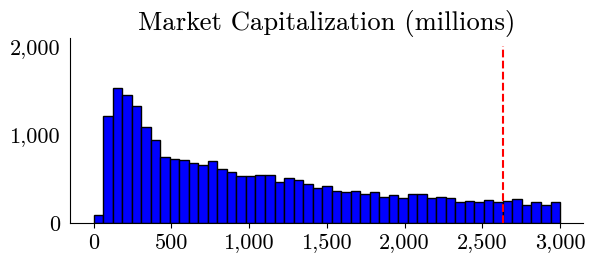

In [167]:
series = tdfs.Market_Cap

display(pd.DataFrame(series.describe()))
pd.DataFrame(series.describe()).to_excel(folder + '/mkt_cap.xlsx')

plt.figure(figsize=(6.75,2.5))
plt.subplots_adjust(left=0.12, right=0.88, bottom=0.13, top=0.87)
plt.hist(series, bins=np.linspace(0,3000,50), color='blue', edgecolor='black')
plt.vlines(series.median(), ymin=0, ymax=2000, color='red', ls='--')
plt.xticks(np.linspace(0,3000,7))
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(comma))
plt.gca().xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(comma))
plt.title('Market Capitalization (millions)')

plt.savefig(folder + '/mkt_cap.svg', transparent=True)
plt.show()

,Market_Cap
count,3.561900e+04
mean,1.887243e+04
std,7.362479e+04
min,4.879565e+01
25%,1.048369e+03
50%,3.522847e+03
75%,1.266902e+04
max,2.933331e+06


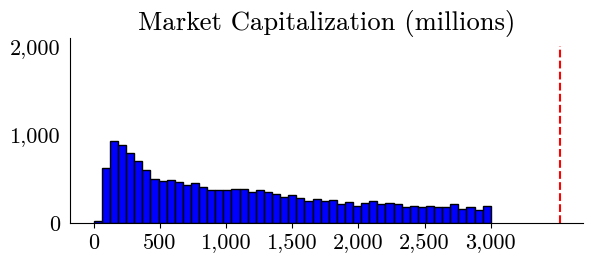

In [169]:
series = tdfs[tdfs.gvkey.isin(current_public_gvkeys)].Market_Cap

display(pd.DataFrame(series.describe()))
pd.DataFrame(series.describe()).to_excel(folder + '/current_public_mkt_cap.xlsx')

plt.figure(figsize=(6.75,2.5))
plt.subplots_adjust(left=0.12, right=0.88, bottom=0.13, top=0.87)
plt.hist(series, bins=np.linspace(0,3000,50), color='blue', edgecolor='black')
plt.vlines(series.median(), ymin=0, ymax=2000, color='red', ls='--')
plt.xticks(np.linspace(0,3000,7))
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(comma))
plt.gca().xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(comma))
plt.title('Market Capitalization (millions)')

plt.savefig(folder + '/current_public_mkt_cap.svg', transparent=True)
plt.show()

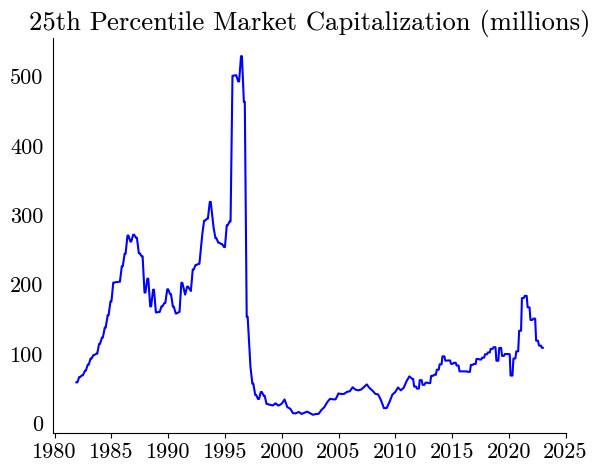

In [163]:
if folder == 'Filtered Histograms':
    fig, ax = plt.subplots(figsize=(6.75,5.33))
    plt.subplots_adjust(left=0.12, right=0.88, bottom=0.13, top=0.87)
    ax.set_title(str(round(p_mktcap * 100)) + 'th Percentile Market Capitalization (millions)')
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(comma))
    #ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(comma))
    ax.plot(tdfs[['datadate','Market_Cap_' + str(round(p_mktcap * 100)) + 'p']].groupby('datadate').first(), color='blue')
    #ax.set_xticks([
    #    np.datetime64('1980-01-01'),
    #    np.datetime64('1990-01-01'),
    #    np.datetime64('2000-01-01'),
    #    np.datetime64('2010-01-01'),
    #    np.datetime64('2020-01-01'),
    #])
    plt.savefig('Filtered Histograms/MktCap_percentile.svg')
    plt.show()

#### Beta (Levered)

,beta
count,46437.000000
mean,1.080569
std,0.489783
min,-0.118248
25%,0.703455
50%,1.066929
75%,1.435985
max,3.059022


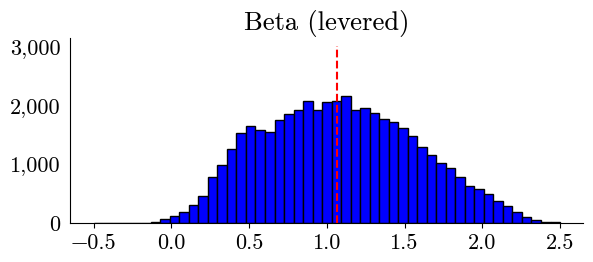

In [165]:
series = tdfs.beta

display(pd.DataFrame(series.describe()))
pd.DataFrame(series.describe()).to_excel(folder + '/beta.xlsx')

plt.figure(figsize=(6.75,2.5))
plt.subplots_adjust(left=0.12, right=0.88, bottom=0.13, top=0.87)
plt.hist(series, bins=np.linspace(-0.5,2.5,50), color='blue', edgecolor='black')
plt.vlines(series.median(), ymin=0, ymax=3000, color='red', ls='--')
plt.xticks(np.linspace(-0.5,2.5,7))
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(comma))
plt.title('Beta (levered)')

plt.savefig(folder + '/beta_levered.svg', transparent=True)
plt.show()

,beta
count,35619.000000
mean,1.099797
std,0.475657
min,-0.118248
25%,0.740264
50%,1.085258
75%,1.441495
max,3.059022


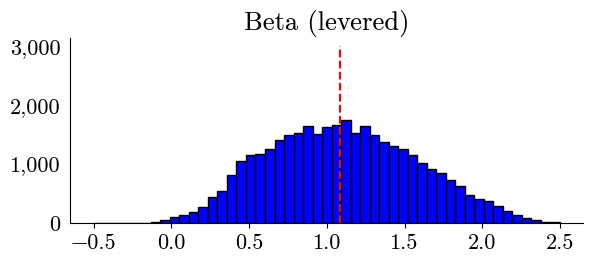

In [170]:
series = tdfs[tdfs.gvkey.isin(current_public_gvkeys)].beta

display(pd.DataFrame(series.describe()))
pd.DataFrame(series.describe()).to_excel(folder + '/current_public_beta.xlsx')

plt.figure(figsize=(6.75,2.5))
plt.subplots_adjust(left=0.12, right=0.88, bottom=0.13, top=0.87)
plt.hist(series, bins=np.linspace(-0.5,2.5,50), color='blue', edgecolor='black')
plt.vlines(series.median(), ymin=0, ymax=3000, color='red', ls='--')
plt.xticks(np.linspace(-0.5,2.5,7))
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(comma))
plt.title('Beta (levered)')

plt.savefig(folder + '/current_public_beta_levered.svg', transparent=True)
plt.show()

#### Beta (Unlevered)

,beta_ul
count,46437.000000
mean,0.942121
std,1.814988
min,-13.166756
25%,0.535549
50%,0.893022
75%,1.243033
max,343.351614


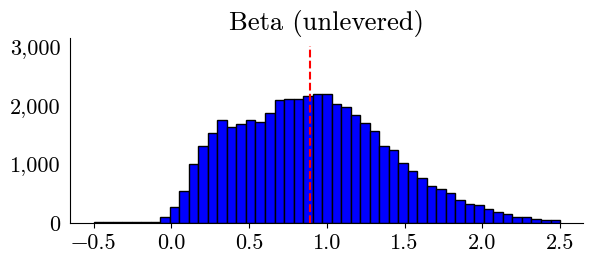

In [171]:
series = tdfs.beta_ul

display(pd.DataFrame(series.describe()))
pd.DataFrame(series.describe()).to_excel(folder + '/beta_unlevered.xlsx')

plt.figure(figsize=(6.75,2.5))
plt.subplots_adjust(left=0.12, right=0.88, bottom=0.13, top=0.87)
plt.hist(series, bins=np.linspace(-0.5,2.5,50), color='blue', edgecolor='black')
plt.vlines(series.median(), ymin=0, ymax=3000, color='red', ls='--')
plt.xticks(np.linspace(-0.5,2.5,7))
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(comma))
plt.title('Beta (unlevered)')

plt.savefig(folder + '/beta_unlevered.svg', transparent=True)
plt.show()

,beta_ul
count,35619.000000
mean,0.951790
std,0.818832
min,-13.166756
25%,0.582764
50%,0.909657
75%,1.244658
max,59.992197


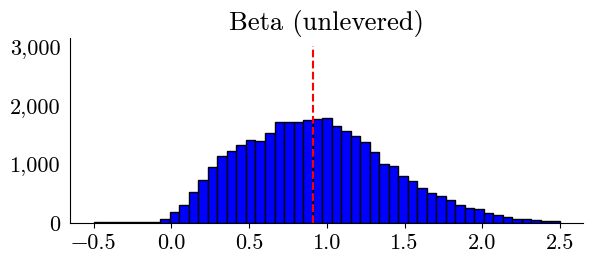

In [172]:
series = tdfs[tdfs.gvkey.isin(current_public_gvkeys)].beta_ul

display(pd.DataFrame(series.describe()))
pd.DataFrame(series.describe()).to_excel(folder + '/current_public_beta_unlevered.xlsx')

plt.figure(figsize=(6.75,2.5))
plt.subplots_adjust(left=0.12, right=0.88, bottom=0.13, top=0.87)
plt.hist(series, bins=np.linspace(-0.5,2.5,50), color='blue', edgecolor='black')
plt.vlines(series.median(), ymin=0, ymax=3000, color='red', ls='--')
plt.xticks(np.linspace(-0.5,2.5,7))
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(comma))
plt.title('Beta (unlevered)')

plt.savefig(folder + '/current_public_beta_unlevered.svg', transparent=True)
plt.show()

#### Tax Rate

,Tax_Rate
count,46437.000000
mean,0.225124
std,2.305404
min,-75.092037
25%,0.154708
50%,0.260225
75%,0.355990
max,191.000000


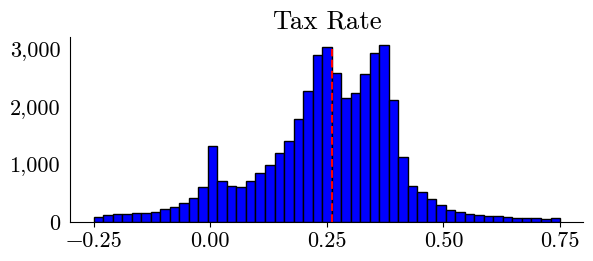

In [159]:
series = tdfs.Tax_Rate

display(pd.DataFrame(series.describe()))
pd.DataFrame(series.describe()).to_excel(folder + '/tax_rate.xlsx')

plt.figure(figsize=(6.75,2.5))
plt.subplots_adjust(left=0.12, right=0.88, bottom=0.13, top=0.87)
plt.hist(series, bins=np.linspace(-0.25,0.75,50), color='blue', edgecolor='black')
plt.vlines(series.median(), ymin=0, ymax=3000, color='red', ls='--')
plt.xticks(np.linspace(-0.25,.75,5))
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(comma))
plt.title('Tax Rate')

plt.savefig(folder + '/tax_rate.svg', transparent=True)
plt.show()

,Tax_Rate
count,35619.000000
mean,0.221368
std,2.346519
min,-75.092037
25%,0.155547
50%,0.251031
75%,0.346250
max,191.000000


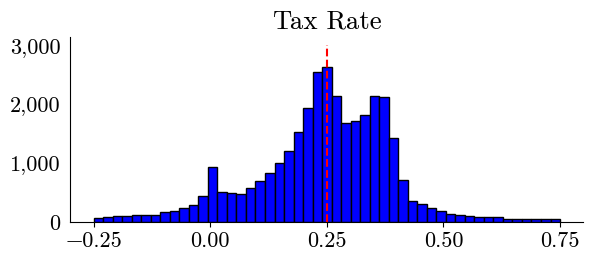

In [156]:
series = tdfs[tdfs.gvkey.isin(current_public_gvkeys)].Tax_Rate

display(pd.DataFrame(series.describe()))
pd.DataFrame(series.describe()).to_excel(folder + '/current_pubic_tax_rate.xlsx')

plt.figure(figsize=(6.75,2.5))
plt.subplots_adjust(left=0.12, right=0.88, bottom=0.13, top=0.87)
plt.hist(series, bins=np.linspace(-0.25,0.75,50), color='blue', edgecolor='black')
plt.vlines(series.median(), ymin=0, ymax=3000, color='red', ls='--')
plt.xticks(np.linspace(-0.25,.75,5))
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(comma))
plt.title('Tax Rate')

plt.savefig(folder + '/current_public_tax_rate.svg', transparent=True)
plt.show()

#### Required Return

,RR
count,46437.000000
mean,0.078819
std,0.126525
min,-0.920996
25%,0.053289
50%,0.075243
75%,0.098702
max,24.035870


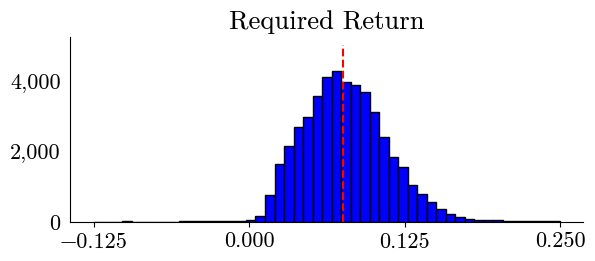

In [173]:
series = tdfs.RR

display(pd.DataFrame(series.describe()))
pd.DataFrame(series.describe()).to_excel(folder + '/required_return_annual.xlsx')

plt.figure(figsize=(6.75,2.5))
plt.subplots_adjust(left=0.12, right=0.88, bottom=0.13, top=0.87)
plt.hist(series, bins=np.linspace(-0.125,0.25,50), color='blue', edgecolor='black')
plt.vlines(series.median(), ymin=0, ymax=5000, color='red', ls='--')
plt.xticks(np.linspace(-0.125,0.25,4))
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(comma))
plt.title('Required Return')

plt.savefig(folder + '/required_return_annual.svg', transparent=True)
plt.show()

,RR
count,35619.000000
mean,0.078379
std,0.056891
min,-0.920996
25%,0.053719
50%,0.075357
75%,0.098845
max,4.224121


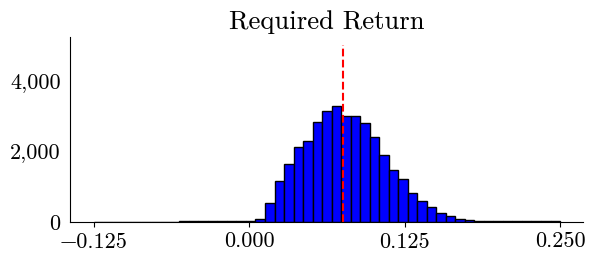

In [174]:
series = tdfs[tdfs.gvkey.isin(current_public_gvkeys)].RR

display(pd.DataFrame(series.describe()))
pd.DataFrame(series.describe()).to_excel(folder + '/current_public_required_return_annual.xlsx')

plt.figure(figsize=(6.75,2.5))
plt.subplots_adjust(left=0.12, right=0.88, bottom=0.13, top=0.87)
plt.hist(series, bins=np.linspace(-0.125,0.25,50), color='blue', edgecolor='black')
plt.vlines(series.median(), ymin=0, ymax=5000, color='red', ls='--')
plt.xticks(np.linspace(-0.125,0.25,4))
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(comma))
plt.title('Required Return')

plt.savefig(folder + '/current_public_required_return_annual.svg', transparent=True)
plt.show()

#### Quarterly Required Return

,qRR
count,46437.000000
mean,0.018829
std,0.013373
min,-0.469834
25%,0.013064
50%,0.018302
75%,0.023812
max,1.236870


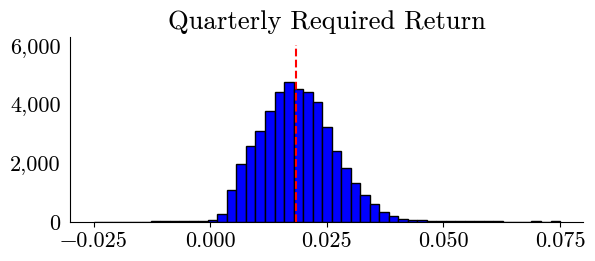

In [176]:
series = tdfs.qRR

display(pd.DataFrame(series.describe()))
pd.DataFrame(series.describe()).to_excel(folder + '/required_return_quarterly.xlsx')

plt.figure(figsize=(6.75,2.5))
plt.subplots_adjust(left=0.12, right=0.88, bottom=0.13, top=0.87)
plt.hist(series, bins=np.linspace(-0.025,0.075,50), color='blue', edgecolor='black')
plt.vlines(series.median(), ymin=0, ymax=6000, color='red', ls='--')
plt.xticks(np.linspace(-0.025,0.075,5))
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(comma))
plt.title('Quarterly Required Return')

plt.savefig(folder + '/required_return_quarterly.svg', transparent=True)
plt.show()

,qRR
count,35619.000000
mean,0.018840
std,0.011634
min,-0.469834
25%,0.013167
50%,0.018329
75%,0.023845
max,0.511831


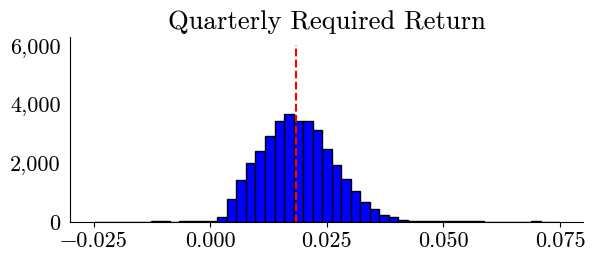

In [177]:
series = tdfs[tdfs.gvkey.isin(current_public_gvkeys)].qRR

display(pd.DataFrame(series.describe()))
pd.DataFrame(series.describe()).to_excel(folder + '/current_public_required_return_quarterly.xlsx')

plt.figure(figsize=(6.75,2.5))
plt.subplots_adjust(left=0.12, right=0.88, bottom=0.13, top=0.87)
plt.hist(series, bins=np.linspace(-0.025,0.075,50), color='blue', edgecolor='black')
plt.vlines(series.median(), ymin=0, ymax=6000, color='red', ls='--')
plt.xticks(np.linspace(-0.025,0.075,5))
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(comma))
plt.title('Quarterly Required Return')

plt.savefig(folder + '/current_public_required_return_quarterly.svg', transparent=True)
plt.show()

#### Lerner

,lerner
count,46437.000000
mean,0.071177
std,0.227225
min,-1.506170
25%,-0.025813
50%,0.049690
75%,0.154202
max,1.857894


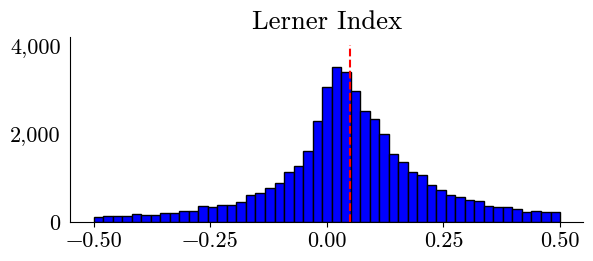

In [178]:
series = tdfs.lerner

display(pd.DataFrame(series.describe()))
pd.DataFrame(series.describe()).to_excel(folder + '/lerner.xlsx')

plt.figure(figsize=(6.75,2.5))
plt.subplots_adjust(left=0.12, right=0.88, bottom=0.13, top=0.87)
plt.hist(series, bins=np.linspace(-0.5,0.5,50), color='blue', edgecolor='black')
plt.vlines(series.median(), ymin=0, ymax=4000, color='red', ls='--')
plt.xticks(np.linspace(-0.5,0.5,5))
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(comma))
plt.title('Lerner Index')

plt.savefig(folder + '/lerner.svg', transparent=True)
plt.show()

,lerner
count,35619.000000
mean,0.067917
std,0.223332
min,-1.491492
25%,-0.025916
50%,0.048504
75%,0.150903
max,1.857894


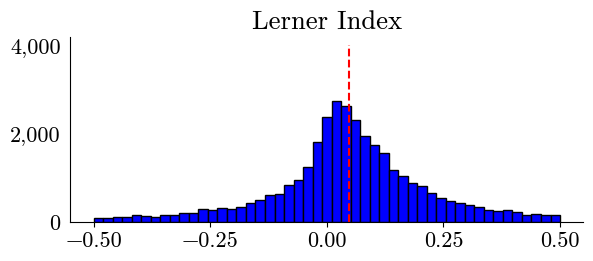

In [179]:
series = tdfs[tdfs.gvkey.isin(current_public_gvkeys)].lerner

display(pd.DataFrame(series.describe()))
pd.DataFrame(series.describe()).to_excel(folder + '/current_public_lerner.xlsx')

plt.figure(figsize=(6.75,2.5))
plt.subplots_adjust(left=0.12, right=0.88, bottom=0.13, top=0.87)
plt.hist(series, bins=np.linspace(-0.5,0.5,50), color='blue', edgecolor='black')
plt.vlines(series.median(), ymin=0, ymax=4000, color='red', ls='--')
plt.xticks(np.linspace(-0.5,0.5,5))
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(comma))
plt.title('Lerner Index')

plt.savefig(folder + '/current_public_lerner.svg', transparent=True)
plt.show()

#### Price-Cost Margin

,price_cost_margin
count,46437.000000
mean,0.182479
std,0.147360
min,-0.288142
25%,0.077521
50%,0.153820
75%,0.256305
max,0.944923


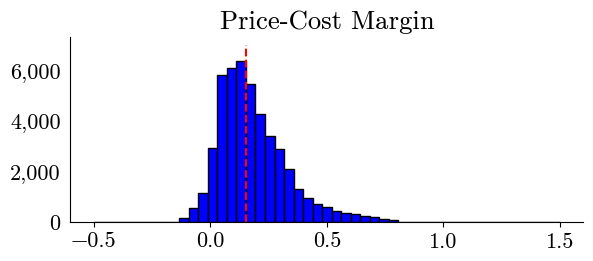

In [182]:
series = tdfs.price_cost_margin

display(pd.DataFrame(series.describe()))
pd.DataFrame(series.describe()).to_excel(folder + '/price_cost_margin.xlsx')

plt.figure(figsize=(6.75,2.5))
plt.subplots_adjust(left=0.12, right=0.88, bottom=0.13, top=0.87)
plt.hist(series, bins=np.linspace(-0.5,1.5,50), color='blue', edgecolor='black')
plt.vlines(series.median(), ymin=0, ymax=7000, color='red', ls='--')
plt.xticks(np.linspace(-0.5,1.5,5))
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(comma))
plt.title('Price-Cost Margin')

plt.savefig(folder + '/price_cost_margin.svg', transparent=True)
plt.show()

,price_cost_margin
count,35619.000000
mean,0.179865
std,0.144899
min,-0.288142
25%,0.076831
50%,0.150812
75%,0.251426
max,0.944923


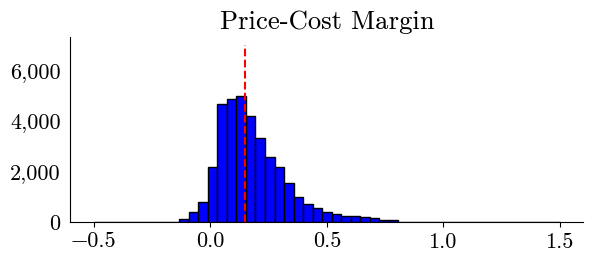

In [183]:
series = tdfs[tdfs.gvkey.isin(current_public_gvkeys)].price_cost_margin

display(pd.DataFrame(series.describe()))
pd.DataFrame(series.describe()).to_excel(folder + '/current_public_price_cost_margin.xlsx')

plt.figure(figsize=(6.75,2.5))
plt.subplots_adjust(left=0.12, right=0.88, bottom=0.13, top=0.87)
plt.hist(series, bins=np.linspace(-0.5,1.5,50), color='blue', edgecolor='black')
plt.vlines(series.median(), ymin=0, ymax=7000, color='red', ls='--')
plt.xticks(np.linspace(-0.5,1.5,5))
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(comma))
plt.title('Price-Cost Margin')

plt.savefig(folder + '/current_public_price_cost_margin.svg', transparent=True)
plt.show()

#### EBIT Margin

,EBIT_margin
count,46437.000000
mean,0.105391
std,0.114461
min,-1.498403
25%,0.051874
50%,0.106782
75%,0.172891
max,0.387456


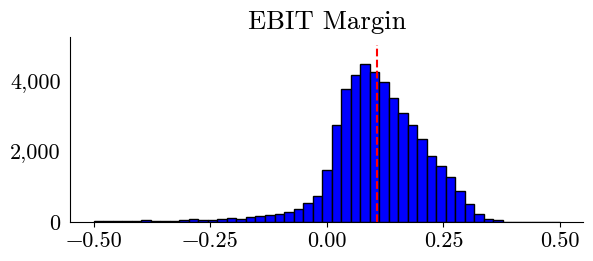

In [184]:
series = tdfs.EBIT_margin

display(pd.DataFrame(series.describe()))
pd.DataFrame(series.describe()).to_excel(folder + '/ebit_margin.xlsx')

plt.figure(figsize=(6.75,2.5))
plt.subplots_adjust(left=0.12, right=0.88, bottom=0.13, top=0.87)
plt.hist(series, bins=np.linspace(-0.5,0.5,50), color='blue', edgecolor='black')
plt.vlines(series.median(), ymin=0, ymax=5000, color='red', ls='--')
plt.xticks(np.linspace(-0.5,0.5,5))
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(comma))
plt.title('EBIT Margin')

plt.savefig(folder + '/ebit_margin.svg', transparent=True)
plt.show()

,EBIT_margin
count,35619.000000
mean,0.107461
std,0.112272
min,-1.498403
25%,0.055211
50%,0.108025
75%,0.172102
max,0.387456


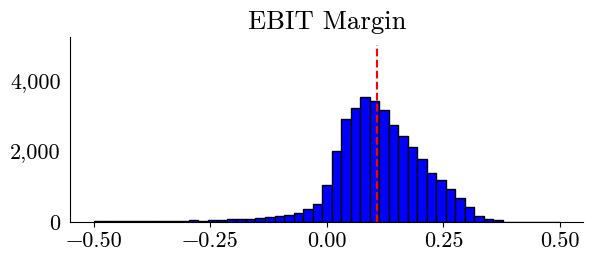

In [185]:
series = tdfs[tdfs.gvkey.isin(current_public_gvkeys)].EBIT_margin

display(pd.DataFrame(series.describe()))
pd.DataFrame(series.describe()).to_excel(folder + '/current_public_ebit_margin.xlsx')

plt.figure(figsize=(6.75,2.5))
plt.subplots_adjust(left=0.12, right=0.88, bottom=0.13, top=0.87)
plt.hist(series, bins=np.linspace(-0.5,0.5,50), color='blue', edgecolor='black')
plt.vlines(series.median(), ymin=0, ymax=5000, color='red', ls='--')
plt.xticks(np.linspace(-0.5,0.5,5))
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(comma))
plt.title('EBIT Margin')

plt.savefig(folder + '/current_public_ebit_margin.svg', transparent=True)
plt.show()

#### ROIC

,ROIC
count,46437.000000
mean,0.025345
std,0.079935
min,-4.720355
25%,0.012015
50%,0.021875
75%,0.034995
max,6.931708


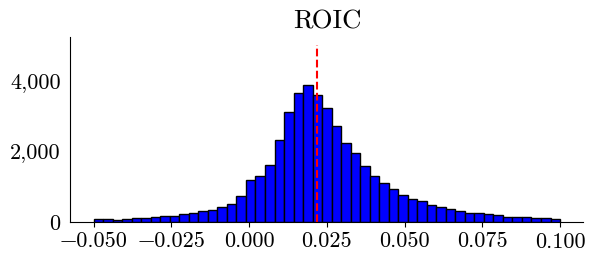

In [186]:
series = tdfs.ROIC

display(pd.DataFrame(series.describe()))
pd.DataFrame(series.describe()).to_excel(folder + '/roic_quarterly.xlsx')

plt.figure(figsize=(6.75,2.5))
plt.subplots_adjust(left=0.12, right=0.88, bottom=0.13, top=0.87)
plt.hist(series, bins=np.linspace(-0.05,0.1,50), color='blue', edgecolor='black')
plt.vlines(series.median(), ymin=0, ymax=5000, color='red', ls='--')
plt.xticks(np.linspace(-0.05,0.1,7))
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(comma))
plt.title('ROIC')

plt.savefig(folder + '/roic_quarterly.svg', transparent=True)
plt.show()

,ROIC
count,35619.000000
mean,0.027213
std,0.073156
min,-4.720355
25%,0.013036
50%,0.023062
75%,0.036878
max,6.537500


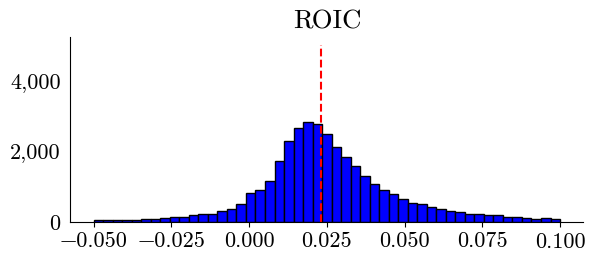

In [187]:
series = tdfs[tdfs.gvkey.isin(current_public_gvkeys)].ROIC

display(pd.DataFrame(series.describe()))
pd.DataFrame(series.describe()).to_excel(folder + '/current_public_roic_quarterly.xlsx')

plt.figure(figsize=(6.75,2.5))
plt.subplots_adjust(left=0.12, right=0.88, bottom=0.13, top=0.87)
plt.hist(series, bins=np.linspace(-0.05,0.1,50), color='blue', edgecolor='black')
plt.vlines(series.median(), ymin=0, ymax=5000, color='red', ls='--')
plt.xticks(np.linspace(-0.05,0.1,7))
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(comma))
plt.title('ROIC')

plt.savefig(folder + '/current_public_roic_quarterly.svg', transparent=True)
plt.show()

#### Marginal ROIC

,mroic
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


C:\Users\jdsch\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6762: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
C:\Users\jdsch\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
C:\Users\jdsch\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


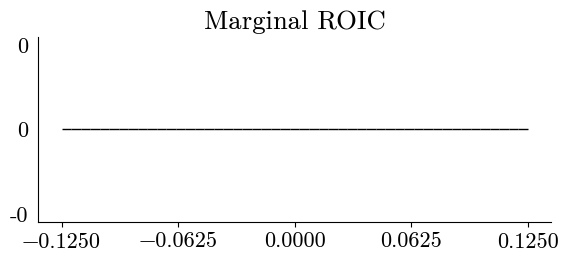

In [111]:
series = tdfs.mroic

display(pd.DataFrame(series.describe()))
pd.DataFrame(series.describe()).to_excel(folder + '/marginal_roic_quarterly.xlsx')

plt.figure(figsize=(6.75,2.5))
plt.subplots_adjust(left=0.12, right=0.88, bottom=0.13, top=0.87)
plt.hist(series, bins=np.linspace(-0.125,0.125,50), color='blue', edgecolor='black')
plt.vlines(series.median(), ymin=0, ymax=45000, color='red', ls='--')
plt.xticks(np.linspace(-0.125,0.125,5))
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(comma))
plt.title('Marginal ROIC')

plt.savefig(folder + '/marginal_roic_quarterly.svg', transparent=True)
plt.show()

,mroic
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


C:\Users\jdsch\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6762: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
C:\Users\jdsch\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
C:\Users\jdsch\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


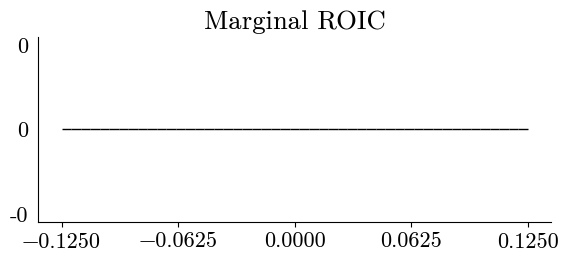

In [112]:
series = tdfs[tdfs.gvkey.isin(current_public_gvkeys)].mroic

display(pd.DataFrame(series.describe()))
pd.DataFrame(series.describe()).to_excel(folder + '/current_public_marginal_roic_quarterly.xlsx')

plt.figure(figsize=(6.75,2.5))
plt.subplots_adjust(left=0.12, right=0.88, bottom=0.13, top=0.87)
plt.hist(series, bins=np.linspace(-0.125,0.125,50), color='blue', edgecolor='black')
plt.vlines(series.median(), ymin=0, ymax=45000, color='red', ls='--')
plt.xticks(np.linspace(-0.125,0.125,5))
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(comma))
plt.title('Marginal ROIC')

plt.savefig(folder + '/current_public_marginal_roic_quarterly.svg', transparent=True)
plt.show()

#### Tobin's q

,tobins_q
count,46437.000000
mean,1.606451
std,1.589750
min,-0.059231
25%,0.789530
50%,1.134343
75%,1.844846
max,31.660161


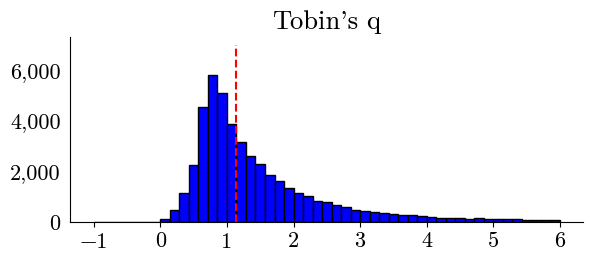

In [188]:
series = tdfs.tobins_q

display(pd.DataFrame(series.describe()))
pd.DataFrame(series.describe()).to_excel(folder + '/tobins_q.xlsx')

plt.figure(figsize=(6.75,2.5))
plt.subplots_adjust(left=0.12, right=0.88, bottom=0.13, top=0.87)
plt.hist(series, bins=np.linspace(-1,6,50), color='blue', edgecolor='black')
plt.vlines(series.median(), ymin=0, ymax=7000, color='red', ls='--')
plt.xticks(np.linspace(-1,6,8))
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(comma))
plt.title('Tobin’s q')

plt.savefig(folder + '/tobins_q.svg', transparent=True)
plt.show()

,tobins_q
count,35619.000000
mean,1.693852
std,1.690805
min,-0.059231
25%,0.820318
50%,1.204823
75%,1.948427
max,31.660161


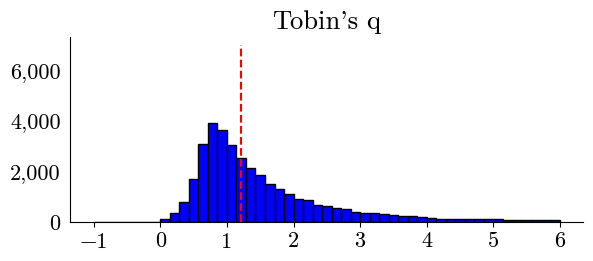

In [189]:
series = tdfs[tdfs.gvkey.isin(current_public_gvkeys)].tobins_q

display(pd.DataFrame(series.describe()))
pd.DataFrame(series.describe()).to_excel(folder + '/current_public_tobins_q.xlsx')

plt.figure(figsize=(6.75,2.5))
plt.subplots_adjust(left=0.12, right=0.88, bottom=0.13, top=0.87)
plt.hist(series, bins=np.linspace(-1,6,50), color='blue', edgecolor='black')
plt.vlines(series.median(), ymin=0, ymax=7000, color='red', ls='--')
plt.xticks(np.linspace(-1,6,8))
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(comma))
plt.title('Tobin’s q')

plt.savefig(folder + '/current_public_tobins_q.svg', transparent=True)
plt.show()

#### Market Share

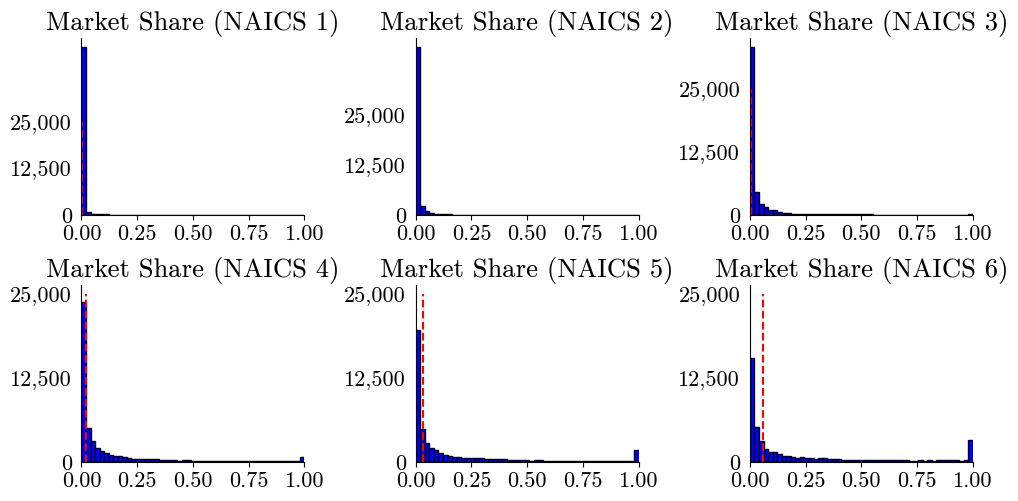

In [191]:
fig, ax = plt.subplots(2, 3, figsize=(11.5, 5.5))
plt.subplots_adjust(hspace=0.4, wspace=0.5)

for i in range(1, 7, 1):
    series = tdfs['mktshare' + str(i)]
    #print((i-1)//3, (i-1)%3)
    #display(series.describe())
    ax[(i-1)//3, (i-1)%3].hist(series, bins=np.linspace(0,1,50), color='blue', edgecolor='black')
    ax[(i-1)//3, (i-1)%3].vlines(series.median(), ymin=0, ymax=25_000, color='red', ls='--')
    ax[(i-1)//3, (i-1)%3].set_xticks(np.linspace(0,1,5))
    ax[(i-1)//3, (i-1)%3].set_yticks(np.linspace(0,25_000,3))
    #ax[(i-1)//2, (i-1)%2].set_ylim(0, 50_000)
    ax[(i-1)//3, (i-1)%3].set_xlim(0, 1)
    ax[(i-1)//3, (i-1)%3].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(comma))
    ax[(i-1)//3, (i-1)%3].set_title('Market Share (NAICS '+str(i)+')')
    
plt.savefig(folder + '/market_share.svg', transparent=True)
plt.show()

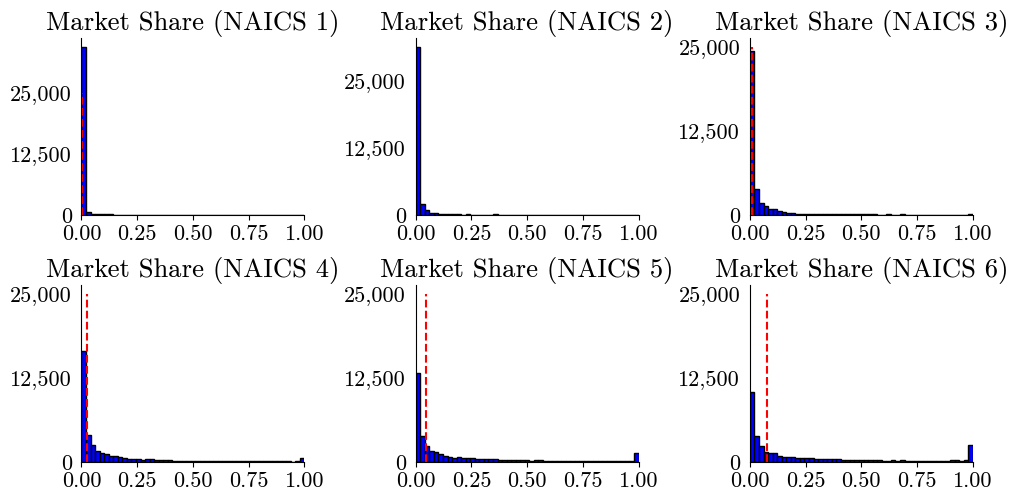

In [192]:
fig, ax = plt.subplots(2, 3, figsize=(11.5, 5.5))
plt.subplots_adjust(hspace=0.4, wspace=0.5)

for i in range(1, 7, 1):
    series = tdfs[tdfs.gvkey.isin(current_public_gvkeys)]['mktshare' + str(i)]
    #print((i-1)//3, (i-1)%3)
    #display(series.describe())
    ax[(i-1)//3, (i-1)%3].hist(series, bins=np.linspace(0,1,50), color='blue', edgecolor='black')
    ax[(i-1)//3, (i-1)%3].vlines(series.median(), ymin=0, ymax=25_000, color='red', ls='--')
    ax[(i-1)//3, (i-1)%3].set_xticks(np.linspace(0,1,5))
    ax[(i-1)//3, (i-1)%3].set_yticks(np.linspace(0,25_000,3))
    #ax[(i-1)//2, (i-1)%2].set_ylim(0, 50_000)
    ax[(i-1)//3, (i-1)%3].set_xlim(0, 1)
    ax[(i-1)//3, (i-1)%3].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(comma))
    ax[(i-1)//3, (i-1)%3].set_title('Market Share (NAICS '+str(i)+')')
    
plt.savefig(folder + '/current_public_market_share.svg', transparent=True)
plt.show()

#### Hirshman-Herfindahl Index

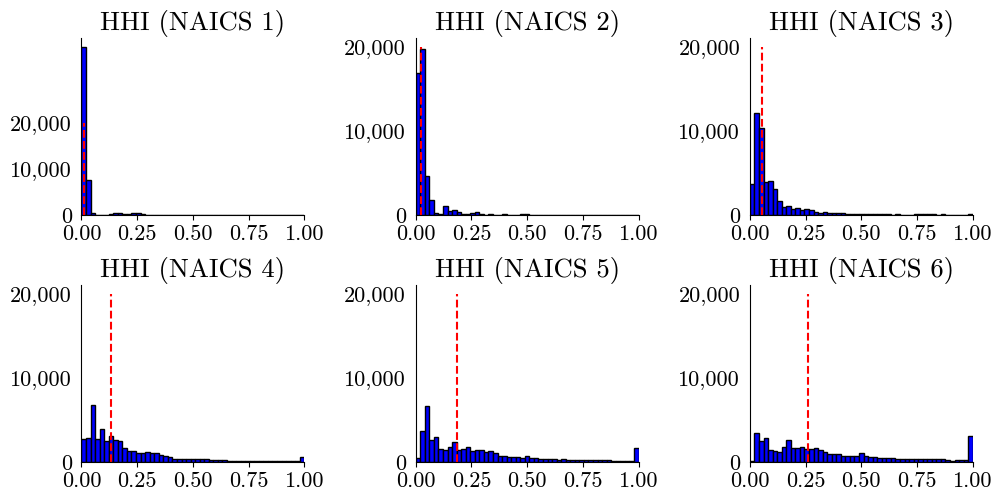

In [194]:
fig, ax = plt.subplots(2, 3, figsize=(11.5, 5.5))
plt.subplots_adjust(hspace=0.4, wspace=0.5)

for i in range(1, 7, 1):
    series = tdfs['hhi' + str(i)]
    #print('\nHHI', 1)
    #display(series.describe())
    ax[(i-1)//3, (i-1)%3].hist(series, bins=np.linspace(0,1,50), color='blue', edgecolor='black')
    ax[(i-1)//3, (i-1)%3].vlines(series.median(), ymin=0, ymax=20_000, color='red', ls='--')
    ax[(i-1)//3, (i-1)%3].set_xticks(np.linspace(0,1,5))
    ax[(i-1)//3, (i-1)%3].set_yticks(np.linspace(0,20_000,3))
    #ax[(i-1)//2, (i-1)%2].set_ylim(0, 50_000)
    ax[(i-1)//3, (i-1)%3].set_xlim(0, 1)
    ax[(i-1)//3, (i-1)%3].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(comma))
    ax[(i-1)//3, (i-1)%3].set_title('HHI (NAICS '+str(i)+')')
    
plt.savefig(folder + '/hhi.svg', transparent=True)
plt.show()

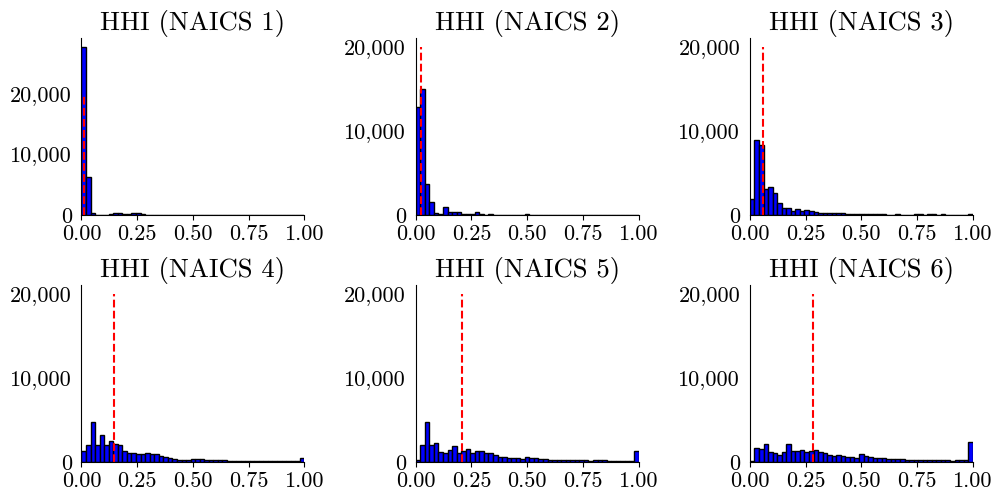

In [195]:
fig, ax = plt.subplots(2, 3, figsize=(11.5, 5.5))
plt.subplots_adjust(hspace=0.4, wspace=0.5)

for i in range(1, 7, 1):
    series = tdfs[tdfs.gvkey.isin(current_public_gvkeys)]['hhi' + str(i)]
    #print('\nHHI', 1)
    #display(series.describe())
    ax[(i-1)//3, (i-1)%3].hist(series, bins=np.linspace(0,1,50), color='blue', edgecolor='black')
    ax[(i-1)//3, (i-1)%3].vlines(series.median(), ymin=0, ymax=20_000, color='red', ls='--')
    ax[(i-1)//3, (i-1)%3].set_xticks(np.linspace(0,1,5))
    ax[(i-1)//3, (i-1)%3].set_yticks(np.linspace(0,20_000,3))
    #ax[(i-1)//2, (i-1)%2].set_ylim(0, 50_000)
    ax[(i-1)//3, (i-1)%3].set_xlim(0, 1)
    ax[(i-1)//3, (i-1)%3].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(comma))
    ax[(i-1)//3, (i-1)%3].set_title('HHI (NAICS '+str(i)+')')
    
plt.savefig(folder + '/current_public_hhi.svg', transparent=True)
plt.show()

## Regressions

<a id='regressions_notallCurrent'></a>
Heteroskedastic Regressions

[Click here](#already_calculated) to go to the data loading part.

[Click here](#top) to go to the top.

In [119]:
regfolder = 'Filtered Analysis' if folder == 'Filtered Histograms' else 'Unfiltered Analysis'
print(regfolder)

Filtered Analysis


In [120]:
simple_mod = smf.rlm('beta_ul ~ lerner', data=tdfs[tdfs['lerner_na'] == 0]).fit()

with open(regfolder + "/simple_mod.txt", "w") as text_file:
    text_file.write(str(simple_mod.summary()))

display(simple_mod.summary())
del(simple_mod)

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                beta_ul   No. Observations:                46266
Model:                            RLM   Df Residuals:                    46264
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 29 Jan 2024                                         
Time:                        23:43:24                                         
No. Iterations:                    20                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9030      0.003    361.040      0.000       0.898       0.908
lerner        -0.0682      0.011     -6.493      0.000      -0.089      -0.048
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [121]:
simple_mod1 = smf.rlm('beta_ul ~ lerner + Market_Cap', data=tdfs[tdfs['lerner_na'] == 0]).fit()

with open(regfolder + "/simple_mod1.txt", "w") as text_file:
    text_file.write(str(simple_mod1.summary()))

display(simple_mod1.summary())
del(simple_mod1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                beta_ul   No. Observations:                46266
Model:                            RLM   Df Residuals:                    46263
Method:                          IRLS   Df Model:                            2
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 29 Jan 2024                                         
Time:                        23:43:25                                         
No. Iterations:                    20                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9043      0.003    353.190      0.000       0.899       0.909
lerner        -0.0675      0.011     -6.419      0.000      -0.088      -0.047
Market_Cap -7.745e-08   3.67e-08     -2.109      0.035   -1.49e-07   -5.46e-09
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [122]:
#hreg_abdoh_varela_mod = smf.rlm('beta_ul ~ hhi4 + Market_Cap + np.log(prccq) + np.log(atq) + I((atq - dlttq) / Market_Cap)',
#                                data=tdfs)

hreg_abdoh_varela_mod = smf.rlm('beta_ul ~ hhi4 + Market_Cap', data=tdfs).fit()

with open(regfolder + "/hreg_abdoh_varela_mod.txt", "w") as text_file:
    text_file.write(str(hreg_abdoh_varela_mod.summary()))

display(hreg_abdoh_varela_mod.summary())
del(hreg_abdoh_varela_mod)

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                beta_ul   No. Observations:                46437
Model:                            RLM   Df Residuals:                    46434
Method:                          IRLS   Df Model:                            2
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 29 Jan 2024                                         
Time:                        23:43:26                                         
No. Iterations:                    14                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8501      0.003    251.749      0.000       0.843       0.857
hhi4           0.2493      0.012     20.732      0.000       0.226       0.273
Market_Cap -9.794e-08   3.62e-08     -2.706      0.007   -1.69e-07    -2.7e-08
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [123]:
simple_mod2 = smf.rlm('beta_ul ~ lerner + Market_Cap + np.log(prccq)', data=tdfs[tdfs['lerner_na'] == 0]).fit()

with open(regfolder + "/simple_mod2.txt", "w") as text_file:
    text_file.write(str(simple_mod2.summary()))

display(simple_mod2.summary())
del(simple_mod2)

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                beta_ul   No. Observations:                46266
Model:                            RLM   Df Residuals:                    46262
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 29 Jan 2024                                         
Time:                        23:43:31                                         
No. Iterations:                    17                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.8446      0.009     98.678      0.000       0.828       0.861
lerner           -0.0694      0.010     -6.623      0.000      -0.090      -0.049
Market_Cap    -1.363e-07   3.77e-08     -3.616      0.000    -2.1e-07   -6.24e-08
np.log(prccq)     0.0168      0.002      7.156      0.000       0.012       0.021
=================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [124]:
simple_mod3 = smf.rlm('beta_ul ~ lerner + Market_Cap + np.log(prccq) + C(cyear)', 
                      data=tdfs[tdfs['lerner_na'] == 0]).fit()

with open(regfolder + "/simple_mod3_lerner.txt", "w") as text_file:
    text_file.write(str(simple_mod3.summary()))

display(simple_mod3.summary())
del(simple_mod3)

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                beta_ul   No. Observations:                46266
Model:                            RLM   Df Residuals:                    46221
Method:                          IRLS   Df Model:                           44
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 29 Jan 2024                                         
Time:                        23:43:42                                         
No. Iterations:                    47                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.1843      0.066      2.780      0.005       0.054       0.314
C(cyear)[T.1982]    -0.0458      0.073     -0.626      0.531      -0.189       0.097
C(cyear)[T.1983]    -0.0081      0.073     -0.110      0.912      -0.152       0.136
C(cyear)[T.1984]    -0.0176      0.074     -0.239      0.811      -0.162       0.127
C(cyear)[T.1985]     0.0033      0.074      0.044      0.965      -0.142       0.149
C(cyear)[T.1986]     0.1033      0.075      1.383      0.167      -0.043       0.250
C(cyear)[T.1987]     0.0899      0.075      1.192      0.233      -0.058       0.238
C(cyear)[T.1988]     0.0646      0.075      0.859      0.390      -0.083       0.212
C(cyear)[T.1989]     0.0572      0.076      0.748      0.454      -0.093       0.207
C(cyear)[T.1990]     0.0812      0.077      1.050      0.294      -0.070       0.233
C(cyear)[T.1991]     0.0439      0.077      0.569      0.569      -0.107       0.195
C(cyear)[T.1992]     0.0483      0.077      0.624      0.533      -0.103       0.200
C(cyear)[T.1993]     0.0573      0.077      0.743      0.457      -0.094       0.208
C(cyear)[T.1994]     0.0900      0.078      1.155      0.248      -0.063       0.243
C(cyear)[T.1995]     0.0855      0.080      1.073      0.283      -0.071       0.242
C(cyear)[T.1996]     0.1391      0.081      1.723      0.085      -0.019       0.297
C(cyear)[T.1997]     0.1370      0.079      1.740      0.082      -0.017       0.291
C(cyear)[T.1998]     0.1283      0.081      1.575      0.115      -0.031       0.288
C(cyear)[T.1999]    -0.0150      0.080     -0.188      0.851      -0.172       0.142
C(cyear)[T.2000]    -0.1024      0.081     -1.268      0.205      -0.261       0.056
C(cyear)[T.2001]    -0.1359      0.085     -1.592      0.111      -0.303       0.031
C(cyear)[T.2002]    -0.0981      0.080     -1.221      0.222      -0.255       0.059
C(cyear)[T.2003]    -0.0739      0.075     -0.980      0.327      -0.222       0.074
C(cyear)[T.2004]     0.0181      0.074      0.244      0.807      -0.128       0.164
C(cyear)[T.2005]     0.1053      0.075      1.408      0.159      -0.041       0.252
C(cyear)[T.2006]     0.2201      0.073      3.000      0.003       0.076       0.364
C(cyear)[T.2007]     0.2312      0.074      3.116      0.002       0.086       0.377
C(cyear)[T.2008]     0.3188      0.074      4.292      0.000       0.173       0.464
C(cyear)[T.2009]     0.2399      0.073      3.266      0.001       0.096       0.384
C(cyear)[T.2010]     0.2949      0.073      4.035      0.000       0.152       0.438
C(cyear)[T.2011]     0.7956      0.067     11.804      0.000       0.664       0.928
C(cyear)[T.2012]     0.8776      0.066     13.211      0.000       0.747       1.008
C(cyear)[T.2013]     0.8796      0.066     13.239      0.000       0.749       1.010
C(cyear)[T.2014]     0.

In [125]:
simple_mod3 = smf.rlm('beta_ul ~ price_cost_margin + Market_Cap + np.log(prccq) + C(cyear)', 
                      data=tdfs[tdfs['price_cost_margin_na'] == 0]).fit()

with open(regfolder + "/simple_mod3_pcm.txt", "w") as text_file:
    text_file.write(str(simple_mod3.summary()))

display(simple_mod3.summary())
del(simple_mod3)

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                beta_ul   No. Observations:                46387
Model:                            RLM   Df Residuals:                    46342
Method:                          IRLS   Df Model:                           44
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 29 Jan 2024                                         
Time:                        23:43:49                                         
No. Iterations:                    30                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.1289      0.067      1.936      0.053      -0.002       0.259
C(cyear)[T.1982]      0.0140      0.073      0.192      0.848      -0.129       0.157
C(cyear)[T.1983]      0.0382      0.073      0.520      0.603      -0.106       0.182
C(cyear)[T.1984]      0.0200      0.074      0.270      0.787      -0.125       0.165
C(cyear)[T.1985]      0.0316      0.074      0.425      0.671      -0.114       0.177
C(cyear)[T.1986]      0.1226      0.075      1.637      0.102      -0.024       0.269
C(cyear)[T.1987]      0.1011      0.076      1.336      0.182      -0.047       0.249
C(cyear)[T.1988]      0.0731      0.075      0.970      0.332      -0.075       0.221
C(cyear)[T.1989]      0.0658      0.077      0.858      0.391      -0.084       0.216
C(cyear)[T.1990]      0.0904      0.078      1.165      0.244      -0.062       0.243
C(cyear)[T.1991]      0.0570      0.077      0.737      0.461      -0.095       0.209
C(cyear)[T.1992]      0.0601      0.078      0.775      0.438      -0.092       0.212
C(cyear)[T.1993]      0.0682      0.077      0.881      0.378      -0.083       0.220
C(cyear)[T.1994]      0.1016      0.078      1.300      0.194      -0.052       0.255
C(cyear)[T.1995]      0.0955      0.080      1.195      0.232      -0.061       0.252
C(cyear)[T.1996]      0.1479      0.081      1.827      0.068      -0.011       0.307
C(cyear)[T.1997]      0.1489      0.079      1.885      0.059      -0.006       0.304
C(cyear)[T.1998]      0.1502      0.081      1.848      0.065      -0.009       0.309
C(cyear)[T.1999]      0.0045      0.080      0.056      0.955      -0.152       0.161
C(cyear)[T.2000]     -0.0803      0.081     -0.992      0.321      -0.239       0.078
C(cyear)[T.2001]     -0.1096      0.085     -1.284      0.199      -0.277       0.058
C(cyear)[T.2002]     -0.0736      0.080     -0.921      0.357      -0.230       0.083
C(cyear)[T.2003]     -0.0442      0.075     -0.587      0.557      -0.192       0.103
C(cyear)[T.2004]      0.0487      0.075      0.654      0.513      -0.097       0.195
C(cyear)[T.2005]      0.1365      0.075      1.821      0.069      -0.010       0.283
C(cyear)[T.2006]      0.2533      0.074      3.441      0.001       0.109       0.398
C(cyear)[T.2007]      0.2662      0.074      3.579      0.000       0.120       0.412
C(cyear)[T.2008]      0.3549      0.075      4.763      0.000       0.209       0.501
C(cyear)[T.2009]      0.2774      0.074      3.765      0.000       0.133       0.422
C(cyear)[T.2010]      0.3302      0.073      4.507      0.000       0.187       0.474
C(cyear)[T.2011]      0.8085      0.068     11.963      0.000       0.676       0.941
C(cyear)[T.2012]      0.8962      0.067     13.449      0.000       0.766       1.027
C(cyear)[T.2013]      0.9004      0.067     13.511      0.000       0.770

In [126]:
simple_mod4 = smf.rlm('beta_ul ~ lerner + Market_Cap + np.log(prccq) + naics2 + C(cyear)', 
                      data=tdfs[tdfs['lerner_na'] == 0]).fit()

with open(regfolder + "/simple_mod4_lerner.txt", "w") as text_file:
    text_file.write(str(simple_mod4.summary()))

display(simple_mod4.summary())
del(simple_mod4)

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                beta_ul   No. Observations:                46266
Model:                            RLM   Df Residuals:                    46199
Method:                          IRLS   Df Model:                           66
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 29 Jan 2024                                         
Time:                        23:44:11                                         
No. Iterations:                    50                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.3675      0.067      5.488      0.000       0.236       0.499
naics2[T.21]         0.3910      0.031     12.447      0.000       0.329       0.453
naics2[T.22]        -0.2117      0.030     -7.036      0.000      -0.271      -0.153
naics2[T.23]         0.4246      0.032     13.139      0.000       0.361       0.488
naics2[T.31]         0.1236      0.030      4.124      0.000       0.065       0.182
naics2[T.32]         0.3708      0.029     12.631      0.000       0.313       0.428
naics2[T.33]         0.5282      0.029     18.246      0.000       0.471       0.585
naics2[T.42]         0.3026      0.030     10.037      0.000       0.244       0.362
naics2[T.44]         0.2923      0.031      9.441      0.000       0.232       0.353
naics2[T.45]         0.2647      0.031      8.643      0.000       0.205       0.325
naics2[T.48]         0.1965      0.030      6.480      0.000       0.137       0.256
naics2[T.49]         0.4567      0.057      8.051      0.000       0.345       0.568
naics2[T.51]         0.2967      0.029     10.078      0.000       0.239       0.354
naics2[T.52]         0.2641      0.030      8.740      0.000       0.205       0.323
naics2[T.53]         0.2002      0.033      6.149      0.000       0.136       0.264
naics2[T.54]         0.3428      0.030     11.348      0.000       0.284       0.402
naics2[T.56]         0.2754      0.031      8.813      0.000       0.214       0.337
naics2[T.61]         0.4121      0.037     11.101      0.000       0.339       0.485
naics2[T.62]         0.1489      0.032      4.721      0.000       0.087       0.211
naics2[T.71]         0.3273      0.042      7.709      0.000       0.244       0.410
naics2[T.72]         0.1960      0.032      6.137      0.000       0.133       0.259
naics2[T.81]         0.1385      0.040      3.452      0.001       0.060       0.217
naics2[T.99]         0.1249      0.042      2.958      0.003       0.042       0.208
C(cyear)[T.1982]    -0.0330      0.066     -0.500      0.617      -0.162       0.096
C(cyear)[T.1983]     0.0030      0.066      0.045      0.964      -0.127       0.133
C(cyear)[T.1984]    -0.0076      0.067     -0.114      0.909      -0.138       0.123
C(cyear)[T.1985]     0.0091      0.067      0.135      0.892      -0.122       0.140
C(cyear)[T.1986]     0.1210      0.067      1.793      0.073      -0.011       0.253
C(cyear)[T.1987]     0.1106      0.068      1.623      0.104      -0.023       0.244
C(cyear)[T.1988]     0.0853      0.068      1.257      0.209      -0.048       0.218
C(cyear)[T.1989]     0.0777      0.069      1.126      0.260      -0.058       0.213
C(cyear)[T.1990]     0.1017      0.070      1.456      0.145      -0.035       0.239
C(cyear)[T.1991]     0.0643      0.070      0.923      0.356      -0.072       0.201
C(cyear)[T.1992]     0.

In [127]:
simple_mod4 = smf.rlm('beta_ul ~ price_cost_margin + Market_Cap + np.log(prccq) + naics2 + C(cyear)', 
                      data=tdfs[tdfs['price_cost_margin_na'] == 0]).fit()

with open(regfolder + "/simple_mod4_pcm.txt", "w") as text_file:
    text_file.write(str(simple_mod4.summary()))

display(simple_mod4.summary())
del(simple_mod4)

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                beta_ul   No. Observations:                46387
Model:                            RLM   Df Residuals:                    46320
Method:                          IRLS   Df Model:                           66
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 29 Jan 2024                                         
Time:                        23:44:28                                         
No. Iterations:                    36                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.2860      0.067      4.256      0.000       0.154       0.418
naics2[T.21]          0.4104      0.031     13.082      0.000       0.349       0.472
naics2[T.22]         -0.1838      0.030     -6.102      0.000      -0.243      -0.125
naics2[T.23]          0.4692      0.032     14.454      0.000       0.406       0.533
naics2[T.31]          0.1602      0.030      5.330      0.000       0.101       0.219
naics2[T.32]          0.4018      0.029     13.668      0.000       0.344       0.459
naics2[T.33]          0.5610      0.029     19.342      0.000       0.504       0.618
naics2[T.42]          0.3559      0.030     11.729      0.000       0.296       0.415
naics2[T.44]          0.3386      0.031     10.883      0.000       0.278       0.400
naics2[T.45]          0.2961      0.031      9.644      0.000       0.236       0.356
naics2[T.48]          0.2325      0.030      7.646      0.000       0.173       0.292
naics2[T.49]          0.5056      0.057      8.897      0.000       0.394       0.617
naics2[T.51]          0.3219      0.029     10.924      0.000       0.264       0.380
naics2[T.52]          0.2946      0.030      9.742      0.000       0.235       0.354
naics2[T.53]          0.2181      0.033      6.700      0.000       0.154       0.282
naics2[T.54]          0.3727      0.030     12.317      0.000       0.313       0.432
naics2[T.56]          0.3104      0.031      9.905      0.000       0.249       0.372
naics2[T.61]          0.4328      0.037     11.659      0.000       0.360       0.506
naics2[T.62]          0.1968      0.032      6.216      0.000       0.135       0.259
naics2[T.71]          0.3422      0.042      8.087      0.000       0.259       0.425
naics2[T.72]          0.2231      0.032      6.977      0.000       0.160       0.286
naics2[T.81]          0.1751      0.040      4.350      0.000       0.096       0.254
naics2[T.99]          0.1530      0.042      3.618      0.000       0.070       0.236
C(cyear)[T.1982]      0.0225      0.066      0.342      0.732      -0.107       0.152
C(cyear)[T.1983]      0.0461      0.066      0.697      0.486      -0.084       0.176
C(cyear)[T.1984]      0.0272      0.067      0.408      0.683      -0.103       0.158
C(cyear)[T.1985]      0.0349      0.067      0.522      0.602      -0.096       0.166
C(cyear)[T.1986]      0.1388      0.067      2.056      0.040       0.006       0.271
C(cyear)[T.1987]      0.1205      0.068      1.767      0.077      -0.013       0.254
C(cyear)[T.1988]      0.0928      0.068      1.365      0.172      -0.040       0.226
C(cyear)[T.1989]      0.0853      0.069      1.235      0.217      -0.050       0.221
C(cyear)[T.1990]      0.1100      0.070      1.574      0.115      -0.027       0.247
C(cyear)[T.1991]      0.0765      0.070      1.097      0.273      -0.060

In [128]:
simple_mod4 = smf.rlm('beta_ul ~ hhi4 + Market_Cap + np.log(prccq) + naics2 + C(cyear)', 
                      data=tdfs).fit()

with open(regfolder + "/simple_mod4_hhi.txt", "w") as text_file:
    text_file.write(str(simple_mod4.summary()))

display(simple_mod4.summary())
del(simple_mod4)

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                beta_ul   No. Observations:                46437
Model:                            RLM   Df Residuals:                    46370
Method:                          IRLS   Df Model:                           66
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 29 Jan 2024                                         
Time:                        23:44:50                                         
No. Iterations:                    50                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.2694      0.068      3.970      0.000       0.136       0.402
naics2[T.21]         0.4648      0.033     14.261      0.000       0.401       0.529
naics2[T.22]        -0.1406      0.032     -4.456      0.000      -0.202      -0.079
naics2[T.23]         0.4737      0.033     14.468      0.000       0.409       0.538
naics2[T.31]         0.1763      0.031      5.760      0.000       0.116       0.236
naics2[T.32]         0.4334      0.030     14.240      0.000       0.374       0.493
naics2[T.33]         0.5929      0.030     19.706      0.000       0.534       0.652
naics2[T.42]         0.3607      0.031     11.692      0.000       0.300       0.421
naics2[T.44]         0.3470      0.032     10.978      0.000       0.285       0.409
naics2[T.45]         0.3075      0.031      9.883      0.000       0.247       0.368
naics2[T.48]         0.2591      0.031      8.280      0.000       0.198       0.320
naics2[T.49]         0.4999      0.057      8.774      0.000       0.388       0.612
naics2[T.51]         0.3545      0.030     11.639      0.000       0.295       0.414
naics2[T.52]         0.3310      0.031     10.532      0.000       0.269       0.393
naics2[T.53]         0.2594      0.034      7.725      0.000       0.194       0.325
naics2[T.54]         0.3995      0.031     12.830      0.000       0.339       0.461
naics2[T.56]         0.3281      0.032     10.262      0.000       0.265       0.391
naics2[T.61]         0.4607      0.038     12.239      0.000       0.387       0.535
naics2[T.62]         0.1959      0.032      6.137      0.000       0.133       0.259
naics2[T.71]         0.3749      0.043      8.753      0.000       0.291       0.459
naics2[T.72]         0.2597      0.033      7.861      0.000       0.195       0.324
naics2[T.81]         0.1541      0.040      3.833      0.000       0.075       0.233
naics2[T.99]         0.1768      0.043      4.124      0.000       0.093       0.261
C(cyear)[T.1982]     0.0182      0.066      0.276      0.782      -0.111       0.147
C(cyear)[T.1983]     0.0422      0.066      0.637      0.524      -0.088       0.172
C(cyear)[T.1984]     0.0265      0.067      0.398      0.691      -0.104       0.157
C(cyear)[T.1985]     0.0378      0.067      0.564      0.573      -0.094       0.169
C(cyear)[T.1986]     0.1441      0.068      2.134      0.033       0.012       0.276
C(cyear)[T.1987]     0.1298      0.068      1.903      0.057      -0.004       0.263
C(cyear)[T.1988]     0.1021      0.068      1.501      0.133      -0.031       0.235
C(cyear)[T.1989]     0.0936      0.069      1.354      0.176      -0.042       0.229
C(cyear)[T.1990]     0.1170      0.070      1.672      0.094      -0.020       0.254
C(cyear)[T.1991]     0.0810      0.070      1.161      0.246      -0.056       0.218
C(cyear)[T.1992]     0.

In [129]:
simple_q_mod = smf.rlm('beta_ul ~ tobins_q + Market_Cap + np.log(prccq) + naics2 + C(cyear)', 
                      data=tdfs).fit()

with open(regfolder + "/simple_q_mod.txt", "w") as text_file:
    text_file.write(str(simple_q_mod.summary()))

display(simple_q_mod.summary())
del(simple_q_mod)

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                beta_ul   No. Observations:                46437
Model:                            RLM   Df Residuals:                    46370
Method:                          IRLS   Df Model:                           66
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 29 Jan 2024                                         
Time:                        23:45:12                                         
No. Iterations:                    50                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.3449      0.067      5.148      0.000       0.214       0.476
naics2[T.21]         0.4008      0.031     12.781      0.000       0.339       0.462
naics2[T.22]        -0.2037      0.030     -6.779      0.000      -0.263      -0.145
naics2[T.23]         0.4349      0.032     13.475      0.000       0.372       0.498
naics2[T.31]         0.1267      0.030      4.229      0.000       0.068       0.185
naics2[T.32]         0.3729      0.029     12.716      0.000       0.315       0.430
naics2[T.33]         0.5313      0.029     18.373      0.000       0.475       0.588
naics2[T.42]         0.3142      0.030     10.437      0.000       0.255       0.373
naics2[T.44]         0.3001      0.031      9.704      0.000       0.239       0.361
naics2[T.45]         0.2625      0.031      8.576      0.000       0.202       0.322
naics2[T.48]         0.2040      0.030      6.733      0.000       0.145       0.263
naics2[T.49]         0.4696      0.057      8.274      0.000       0.358       0.581
naics2[T.51]         0.2937      0.029      9.986      0.000       0.236       0.351
naics2[T.52]         0.2739      0.030      9.072      0.000       0.215       0.333
naics2[T.53]         0.1979      0.033      6.086      0.000       0.134       0.262
naics2[T.54]         0.3398      0.030     11.255      0.000       0.281       0.399
naics2[T.56]         0.2751      0.031      8.813      0.000       0.214       0.336
naics2[T.61]         0.4199      0.037     11.312      0.000       0.347       0.493
naics2[T.62]         0.1598      0.031      5.074      0.000       0.098       0.222
naics2[T.71]         0.3237      0.042      7.647      0.000       0.241       0.407
naics2[T.72]         0.1891      0.032      5.919      0.000       0.126       0.252
naics2[T.81]         0.1346      0.040      3.354      0.001       0.056       0.213
naics2[T.99]         0.1315      0.042      3.114      0.002       0.049       0.214
C(cyear)[T.1982]     0.0168      0.066      0.255      0.799      -0.112       0.146
C(cyear)[T.1983]     0.0407      0.066      0.615      0.538      -0.089       0.170
C(cyear)[T.1984]     0.0250      0.067      0.375      0.707      -0.106       0.156
C(cyear)[T.1985]     0.0368      0.067      0.549      0.583      -0.095       0.168
C(cyear)[T.1986]     0.1434      0.068      2.124      0.034       0.011       0.276
C(cyear)[T.1987]     0.1276      0.068      1.871      0.061      -0.006       0.261
C(cyear)[T.1988]     0.0996      0.068      1.465      0.143      -0.034       0.233
C(cyear)[T.1989]     0.0912      0.069      1.320      0.187      -0.044       0.227
C(cyear)[T.1990]     0.1145      0.070      1.638      0.102      -0.023       0.252
C(cyear)[T.1991]     0.0787      0.070      1.128      0.259      -0.058       0.216
C(cyear)[T.1992]     0.

In [130]:
#simple_mod5 = smf.rlm('beta_ul ~ hhi6 + Market_Cap + np.log(prccq) + naics4 + C(cyear)', 
#                      data=tdfs).fit()
#
#with open(regfolder + "/simple_mod5.txt", "w") as text_file:
#    text_file.write(str(simple_mod5.summary()))
#
#display(simple_mod5.summary())
#del(simple_mod5)

In [131]:
simple_mod_i1 = smf.rlm('beta_ul ~ price_cost_margin * Revenue + Market_Cap + naics2 + C(cyear)', 
                        data=tdfs[tdfs['price_cost_margin_na'] == 0]).fit()

with open(regfolder + "/simple_mod_i1_pcm.txt", "w") as text_file:
    text_file.write(str(simple_mod_i1.summary()))
    
display(simple_mod_i1.summary())
del(simple_mod_i1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                beta_ul   No. Observations:                46387
Model:                            RLM   Df Residuals:                    46319
Method:                          IRLS   Df Model:                           67
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 29 Jan 2024                                         
Time:                        23:45:35                                         
No. Iterations:                    50                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.3108      0.067      4.657      0.000       0.180       0.442
naics2[T.21]                  0.4079      0.031     13.058      0.000       0.347       0.469
naics2[T.22]                 -0.1804      0.030     -6.008      0.000      -0.239      -0.122
naics2[T.23]                  0.4683      0.032     14.479      0.000       0.405       0.532
naics2[T.31]                  0.1595      0.030      5.327      0.000       0.101       0.218
naics2[T.32]                  0.4131      0.029     14.102      0.000       0.356       0.471
naics2[T.33]                  0.5626      0.029     19.465      0.000       0.506       0.619
naics2[T.42]                  0.3741      0.030     12.370      0.000       0.315       0.433
naics2[T.44]                  0.3565      0.031     11.498      0.000       0.296       0.417
naics2[T.45]                  0.3176      0.031     10.378      0.000       0.258       0.378
naics2[T.48]                  0.2369      0.030      7.821      0.000       0.178       0.296
naics2[T.49]                  0.5629      0.057      9.935      0.000       0.452       0.674
naics2[T.51]                  0.3161      0.029     10.772      0.000       0.259       0.374
naics2[T.52]                  0.3092      0.030     10.261      0.000       0.250       0.368
naics2[T.53]                  0.2150      0.032      6.627      0.000       0.151       0.279
naics2[T.54]                  0.3704      0.030     12.286      0.000       0.311       0.430
naics2[T.56]                  0.3062      0.031      9.806      0.000       0.245       0.367
naics2[T.61]                  0.4317      0.037     11.675      0.000       0.359       0.504
naics2[T.62]                  0.2124      0.032      6.733      0.000       0.151       0.274
naics2[T.71]                  0.3404      0.042      8.074      0.000       0.258       0.423
naics2[T.72]                  0.2199      0.032      6.903      0.000       0.157       0.282
naics2[T.81]                  0.1682      0.040      4.195      0.000       0.090       0.247
naics2[T.99]                  0.2126      0.042      5.026      0.000       0.130       0.295
C(cyear)[T.1982]              0.0225      0.066      0.342      0.732      -0.106       0.151
C(cyear)[T.1983]              0.0472      0.066      0.716      0.474      -0.082       0.176
C(cyear)[T.1984]              0.0289      0.066      0.435      0.664      -0.101       0.159
C(cyear)[T.1985]              0.0385      0.067      0.577      0.564      -0.092       0.169
C(cyear)[T.1986]              0.1441      0.067      2.144      0.032       0.012       0.276
C(cyear)[T.1987]              0.1249      0.068      1.840      0.066      -0.008       0.258
C(cyear)[T.1988]              0.0966      0.068      1.427      0.154      

In [132]:
simple_mod_i1 = smf.rlm('beta_ul ~ lerner * Revenue + Market_Cap + naics2 + C(cyear)', 
                        data=tdfs[tdfs['lerner_na'] == 0]).fit()

with open(regfolder + "/simple_mod_i1_lerner.txt", "w") as text_file:
    text_file.write(str(simple_mod_i1.summary()))
    
display(simple_mod_i1.summary())
del(simple_mod_i1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                beta_ul   No. Observations:                46266
Model:                            RLM   Df Residuals:                    46198
Method:                          IRLS   Df Model:                           67
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 29 Jan 2024                                         
Time:                        23:45:48                                         
No. Iterations:                    27                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.3913      0.066      5.895      0.000       0.261       0.521
naics2[T.21]         0.3891      0.031     12.460      0.000       0.328       0.450
naics2[T.22]        -0.2054      0.030     -6.865      0.000      -0.264      -0.147
naics2[T.23]         0.4275      0.032     13.305      0.000       0.365       0.491
naics2[T.31]         0.1272      0.030      4.265      0.000       0.069       0.186
naics2[T.32]         0.3864      0.029     13.232      0.000       0.329       0.444
naics2[T.33]         0.5328      0.029     18.506      0.000       0.476       0.589
naics2[T.42]         0.3307      0.030     11.021      0.000       0.272       0.390
naics2[T.44]         0.3178      0.031     10.313      0.000       0.257       0.378
naics2[T.45]         0.2952      0.030      9.684      0.000       0.235       0.355
naics2[T.48]         0.2040      0.030      6.761      0.000       0.145       0.263
naics2[T.49]         0.5301      0.056      9.387      0.000       0.419       0.641
naics2[T.51]         0.2934      0.029     10.027      0.000       0.236       0.351
naics2[T.52]         0.2839      0.030      9.444      0.000       0.225       0.343
naics2[T.53]         0.2006      0.032      6.198      0.000       0.137       0.264
naics2[T.54]         0.3443      0.030     11.462      0.000       0.285       0.403
naics2[T.56]         0.2749      0.031      8.844      0.000       0.214       0.336
naics2[T.61]         0.4135      0.037     11.201      0.000       0.341       0.486
naics2[T.62]         0.1717      0.031      5.470      0.000       0.110       0.233
naics2[T.71]         0.3270      0.042      7.746      0.000       0.244       0.410
naics2[T.72]         0.1956      0.032      6.156      0.000       0.133       0.258
naics2[T.81]         0.1358      0.040      3.403      0.001       0.058       0.214
naics2[T.99]         0.1799      0.042      4.266      0.000       0.097       0.263
C(cyear)[T.1982]    -0.0321      0.066     -0.489      0.625      -0.161       0.096
C(cyear)[T.1983]     0.0052      0.066      0.078      0.938      -0.124       0.134
C(cyear)[T.1984]    -0.0053      0.066     -0.079      0.937      -0.135       0.125
C(cyear)[T.1985]     0.0132      0.067      0.198      0.843      -0.117       0.144
C(cyear)[T.1986]     0.1270      0.067      1.893      0.058      -0.004       0.258
C(cyear)[T.1987]     0.1152      0.068      1.701      0.089      -0.018       0.248
C(cyear)[T.1988]     0.0891      0.068      1.319      0.187      -0.043       0.221
C(cyear)[T.1989]     0.0818      0.069      1.191      0.234      -0.053       0.216
C(cyear)[T.1990]     0.1055      0.069      1.519      0.129      -0.031       0.242
C(cyear)[T.1991]     0.0693      0.069      0.999      0.318      -0.067       0.205
C(cyear)[T.1992]     0.

In [133]:
simple_mod_i1 = smf.rlm('beta_ul ~ hhi4 * Revenue + Market_Cap + naics2 + C(cyear)', 
                        data=tdfs).fit()

with open(regfolder + "/simple_mod_i1_hhi4.txt", "w") as text_file:
    text_file.write(str(simple_mod_i1.summary()))
    
display(simple_mod_i1.summary())
del(simple_mod_i1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                beta_ul   No. Observations:                46437
Model:                            RLM   Df Residuals:                    46369
Method:                          IRLS   Df Model:                           67
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 29 Jan 2024                                         
Time:                        23:46:12                                         
No. Iterations:                    50                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.3060      0.067      4.543      0.000       0.174       0.438
naics2[T.21]         0.4509      0.032     13.884      0.000       0.387       0.515
naics2[T.22]        -0.1472      0.031     -4.675      0.000      -0.209      -0.085
naics2[T.23]         0.4680      0.033     14.344      0.000       0.404       0.532
naics2[T.31]         0.1701      0.031      5.570      0.000       0.110       0.230
naics2[T.32]         0.4398      0.030     14.493      0.000       0.380       0.499
naics2[T.33]         0.5858      0.030     19.519      0.000       0.527       0.645
naics2[T.42]         0.3775      0.031     12.254      0.000       0.317       0.438
naics2[T.44]         0.3594      0.032     11.384      0.000       0.298       0.421
naics2[T.45]         0.3271      0.031     10.529      0.000       0.266       0.388
naics2[T.48]         0.2559      0.031      8.199      0.000       0.195       0.317
naics2[T.49]         0.5491      0.057      9.626      0.000       0.437       0.661
naics2[T.51]         0.3410      0.030     11.236      0.000       0.282       0.401
naics2[T.52]         0.3406      0.031     10.865      0.000       0.279       0.402
naics2[T.53]         0.2470      0.034      7.371      0.000       0.181       0.313
naics2[T.54]         0.3901      0.031     12.558      0.000       0.329       0.451
naics2[T.56]         0.3173      0.032      9.952      0.000       0.255       0.380
naics2[T.61]         0.4535      0.038     12.085      0.000       0.380       0.527
naics2[T.62]         0.2013      0.032      6.291      0.000       0.139       0.264
naics2[T.71]         0.3647      0.043      8.542      0.000       0.281       0.448
naics2[T.72]         0.2469      0.033      7.492      0.000       0.182       0.311
naics2[T.81]         0.1473      0.040      3.678      0.000       0.069       0.226
naics2[T.99]         0.2212      0.043      5.169      0.000       0.137       0.305
C(cyear)[T.1982]     0.0185      0.066      0.282      0.778      -0.110       0.147
C(cyear)[T.1983]     0.0436      0.066      0.662      0.508      -0.086       0.173
C(cyear)[T.1984]     0.0282      0.066      0.425      0.671      -0.102       0.158
C(cyear)[T.1985]     0.0413      0.067      0.618      0.536      -0.090       0.172
C(cyear)[T.1986]     0.1494      0.067      2.221      0.026       0.018       0.281
C(cyear)[T.1987]     0.1335      0.068      1.965      0.049       0.000       0.267
C(cyear)[T.1988]     0.1050      0.068      1.550      0.121      -0.028       0.238
C(cyear)[T.1989]     0.0967      0.069      1.405      0.160      -0.038       0.232
C(cyear)[T.1990]     0.1199      0.070      1.721      0.085      -0.017       0.256
C(cyear)[T.1991]     0.0850      0.070      1.223      0.221      -0.051       0.221
C(cyear)[T.1992]     0.

### Current Public Firms Data Analysis

In [134]:
simple_mod = smf.rlm('beta_ul ~ lerner', 
                     data=tdfs[tdfs.gvkey.isin(current_public_gvkeys) & (tdfs['lerner_na'] == 0)]).fit()

with open(regfolder + "/current_public_simple_mod.txt", "w") as text_file:
    text_file.write(str(simple_mod.summary()))

display(simple_mod.summary())
del(simple_mod)

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                beta_ul   No. Observations:                35520
Model:                            RLM   Df Residuals:                    35518
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 29 Jan 2024                                         
Time:                        23:46:12                                         
No. Iterations:                    16                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9275      0.003    339.895      0.000       0.922       0.933
lerner        -0.1277      0.012    -10.929      0.000      -0.151      -0.105
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [135]:
simple_mod1 = smf.rlm('beta_ul ~ lerner + Market_Cap', 
                      data=tdfs[tdfs.gvkey.isin(current_public_gvkeys) & (tdfs['lerner_na'] == 0)]).fit()

with open(regfolder + "/current_public_simple_mod1.txt", "w") as text_file:
    text_file.write(str(simple_mod1.summary()))

display(simple_mod1.summary())
del(simple_mod1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                beta_ul   No. Observations:                35520
Model:                            RLM   Df Residuals:                    35517
Method:                          IRLS   Df Model:                            2
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 29 Jan 2024                                         
Time:                        23:46:12                                         
No. Iterations:                    16                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9305      0.003    331.931      0.000       0.925       0.936
lerner        -0.1256      0.012    -10.738      0.000      -0.149      -0.103
Market_Cap -1.487e-07   3.55e-08     -4.194      0.000   -2.18e-07   -7.92e-08
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [136]:
#hreg_abdoh_varela_mod = smf.rlm('beta_ul ~ hhi4 + Market_Cap + np.log(prccq) + np.log(atq) + I((atq - dlttq) / Market_Cap)',
#                                data=tdfs)

hreg_abdoh_varela_mod = smf.rlm('beta_ul ~ hhi4 + Market_Cap', 
                                data=tdfs[tdfs.gvkey.isin(current_public_gvkeys)]).fit()

with open(regfolder + "/current_public_hreg_abdoh_varela_mod.txt", "w") as text_file:
    text_file.write(str(hreg_abdoh_varela_mod.summary()))

display(hreg_abdoh_varela_mod.summary())
del(hreg_abdoh_varela_mod)

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                beta_ul   No. Observations:                35619
Model:                            RLM   Df Residuals:                    35616
Method:                          IRLS   Df Model:                            2
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 29 Jan 2024                                         
Time:                        23:46:12                                         
No. Iterations:                    17                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8895      0.004    231.123      0.000       0.882       0.897
hhi4           0.1540      0.013     11.559      0.000       0.128       0.180
Market_Cap -1.635e-07   3.53e-08     -4.628      0.000   -2.33e-07   -9.42e-08
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [137]:
simple_mod2 = smf.rlm('beta_ul ~ lerner + Market_Cap + np.log(prccq)', 
                      data=tdfs[tdfs.gvkey.isin(current_public_gvkeys) & (tdfs['lerner_na'] == 0)]).fit()

with open(regfolder + "/current_public_simple_mod2.txt", "w") as text_file:
    text_file.write(str(simple_mod2.summary()))

display(simple_mod2.summary())
del(simple_mod2)

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                beta_ul   No. Observations:                35520
Model:                            RLM   Df Residuals:                    35516
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 29 Jan 2024                                         
Time:                        23:46:13                                         
No. Iterations:                    21                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.8624      0.010     87.549      0.000       0.843       0.882
lerner           -0.1295      0.012    -11.105      0.000      -0.152      -0.107
Market_Cap    -2.197e-07   3.64e-08     -6.044      0.000   -2.91e-07   -1.48e-07
np.log(prccq)     0.0187      0.003      7.105      0.000       0.014       0.024
=================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [138]:
simple_mod3 = smf.rlm('beta_ul ~ lerner + Market_Cap + np.log(prccq) + C(cyear)', 
                      data=tdfs[tdfs.gvkey.isin(current_public_gvkeys) & (tdfs['lerner_na'] == 0)]).fit()

with open(regfolder + "/current_public_simple_mod3_lerner.txt", "w") as text_file:
    text_file.write(str(simple_mod3.summary()))

display(simple_mod3.summary())
del(simple_mod3)

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                beta_ul   No. Observations:                35520
Model:                            RLM   Df Residuals:                    35475
Method:                          IRLS   Df Model:                           44
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 29 Jan 2024                                         
Time:                        23:46:17                                         
No. Iterations:                    29                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.1587      0.102      1.559      0.119      -0.041       0.358
C(cyear)[T.1982]    -0.0415      0.112     -0.372      0.710      -0.260       0.177
C(cyear)[T.1983]    -0.0067      0.112     -0.060      0.952      -0.227       0.214
C(cyear)[T.1984]    -0.0071      0.113     -0.063      0.950      -0.229       0.215
C(cyear)[T.1985]     0.0147      0.113      0.130      0.896      -0.207       0.236
C(cyear)[T.1986]     0.1254      0.115      1.091      0.275      -0.100       0.351
C(cyear)[T.1987]     0.1217      0.116      1.050      0.294      -0.105       0.349
C(cyear)[T.1988]     0.0856      0.115      0.747      0.455      -0.139       0.310
C(cyear)[T.1989]     0.0896      0.120      0.746      0.456      -0.146       0.325
C(cyear)[T.1990]     0.1138      0.121      0.942      0.346      -0.123       0.351
C(cyear)[T.1991]     0.0609      0.119      0.511      0.610      -0.173       0.294
C(cyear)[T.1992]     0.0516      0.121      0.427      0.669      -0.185       0.289
C(cyear)[T.1993]     0.0718      0.125      0.572      0.567      -0.174       0.318
C(cyear)[T.1994]     0.1040      0.127      0.821      0.412      -0.144       0.352
C(cyear)[T.1995]     0.1097      0.128      0.857      0.391      -0.141       0.361
C(cyear)[T.1996]     0.1939      0.132      1.469      0.142      -0.065       0.453
C(cyear)[T.1997]     0.1842      0.125      1.468      0.142      -0.062       0.430
C(cyear)[T.1998]     0.1577      0.122      1.288      0.198      -0.082       0.398
C(cyear)[T.1999]    -0.0079      0.120     -0.066      0.948      -0.243       0.227
C(cyear)[T.2000]    -0.1104      0.120     -0.921      0.357      -0.345       0.124
C(cyear)[T.2001]    -0.1712      0.138     -1.245      0.213      -0.441       0.098
C(cyear)[T.2002]    -0.1092      0.122     -0.892      0.372      -0.349       0.131
C(cyear)[T.2003]    -0.0974      0.116     -0.842      0.400      -0.324       0.129
C(cyear)[T.2004]    -0.0110      0.113     -0.098      0.922      -0.232       0.209
C(cyear)[T.2005]     0.0797      0.114      0.698      0.485      -0.144       0.303
C(cyear)[T.2006]     0.2737      0.111      2.468      0.014       0.056       0.491
C(cyear)[T.2007]     0.2757      0.111      2.480      0.013       0.058       0.494
C(cyear)[T.2008]     0.3567      0.111      3.226      0.001       0.140       0.573
C(cyear)[T.2009]     0.2735      0.110      2.496      0.013       0.059       0.488
C(cyear)[T.2010]     0.3011      0.110      2.750      0.006       0.087       0.516
C(cyear)[T.2011]     0.8216      0.103      7.980      0.000       0.620       1.023
C(cyear)[T.2012]     0.8771      0.102      8.602      0.000       0.677       1.077
C(cyear)[T.2013]     0.8805      0.102      8.636      0.000       0.681       1.080
C(cyear)[T.2014]     0.

In [139]:
simple_mod3 = smf.rlm('beta_ul ~ price_cost_margin + Market_Cap + np.log(prccq) + C(cyear)', 
                      data=tdfs[tdfs.gvkey.isin(current_public_gvkeys) & (tdfs['price_cost_margin_na'] == 0)]).fit()

with open(regfolder + "/current_public_simple_mod3_pcm.txt", "w") as text_file:
    text_file.write(str(simple_mod3.summary()))

display(simple_mod3.summary())
del(simple_mod3)

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                beta_ul   No. Observations:                35584
Model:                            RLM   Df Residuals:                    35539
Method:                          IRLS   Df Model:                           44
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 29 Jan 2024                                         
Time:                        23:46:21                                         
No. Iterations:                    26                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.1329      0.102      1.303      0.193      -0.067       0.333
C(cyear)[T.1982]      0.0005      0.112      0.004      0.997      -0.218       0.219
C(cyear)[T.1983]      0.0198      0.113      0.176      0.861      -0.201       0.240
C(cyear)[T.1984]      0.0101      0.113      0.089      0.929      -0.212       0.233
C(cyear)[T.1985]      0.0200      0.113      0.176      0.860      -0.202       0.242
C(cyear)[T.1986]      0.1221      0.115      1.060      0.289      -0.104       0.348
C(cyear)[T.1987]      0.1087      0.116      0.936      0.349      -0.119       0.336
C(cyear)[T.1988]      0.0676      0.115      0.589      0.556      -0.157       0.293
C(cyear)[T.1989]      0.0704      0.120      0.585      0.558      -0.166       0.306
C(cyear)[T.1990]      0.0954      0.121      0.788      0.431      -0.142       0.333
C(cyear)[T.1991]      0.0465      0.119      0.389      0.697      -0.188       0.281
C(cyear)[T.1992]      0.0347      0.121      0.287      0.774      -0.203       0.272
C(cyear)[T.1993]      0.0508      0.126      0.404      0.686      -0.196       0.297
C(cyear)[T.1994]      0.0836      0.127      0.659      0.510      -0.165       0.332
C(cyear)[T.1995]      0.0852      0.128      0.665      0.506      -0.166       0.337
C(cyear)[T.1996]      0.1700      0.132      1.286      0.199      -0.089       0.429
C(cyear)[T.1997]      0.1685      0.126      1.341      0.180      -0.078       0.415
C(cyear)[T.1998]      0.1456      0.122      1.195      0.232      -0.093       0.384
C(cyear)[T.1999]     -0.0137      0.120     -0.114      0.909      -0.249       0.222
C(cyear)[T.2000]     -0.1141      0.120     -0.950      0.342      -0.349       0.121
C(cyear)[T.2001]     -0.1699      0.138     -1.233      0.218      -0.440       0.100
C(cyear)[T.2002]     -0.1155      0.121     -0.951      0.341      -0.354       0.123
C(cyear)[T.2003]     -0.0885      0.115     -0.769      0.442      -0.314       0.137
C(cyear)[T.2004]     -0.0052      0.113     -0.046      0.963      -0.226       0.215
C(cyear)[T.2005]      0.0816      0.114      0.713      0.476      -0.143       0.306
C(cyear)[T.2006]      0.2810      0.111      2.530      0.011       0.063       0.499
C(cyear)[T.2007]      0.2836      0.111      2.549      0.011       0.066       0.502
C(cyear)[T.2008]      0.3650      0.111      3.295      0.001       0.148       0.582
C(cyear)[T.2009]      0.2831      0.110      2.579      0.010       0.068       0.498
C(cyear)[T.2010]      0.3075      0.110      2.803      0.005       0.092       0.522
C(cyear)[T.2011]      0.8046      0.103      7.802      0.000       0.602       1.007
C(cyear)[T.2012]      0.8717      0.102      8.534      0.000       0.672       1.072
C(cyear)[T.2013]      0.8780      0.102      8.596      0.000       0.678

In [140]:
simple_mod4 = smf.rlm('beta_ul ~ lerner + Market_Cap + np.log(prccq) + naics2 + C(cyear)', 
                      data=tdfs[tdfs.gvkey.isin(current_public_gvkeys) & (tdfs['lerner_na'] == 0)]).fit()

with open(regfolder + "/current_public_simple_mod4_lerner.txt", "w") as text_file:
    text_file.write(str(simple_mod4.summary()))

display(simple_mod4.summary())
del(simple_mod4)

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                beta_ul   No. Observations:                35520
Model:                            RLM   Df Residuals:                    35453
Method:                          IRLS   Df Model:                           66
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 29 Jan 2024                                         
Time:                        23:46:33                                         
No. Iterations:                    38                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.3654      0.099      3.691      0.000       0.171       0.559
naics2[T.21]         0.3640      0.040      9.116      0.000       0.286       0.442
naics2[T.22]        -0.2450      0.039     -6.308      0.000      -0.321      -0.169
naics2[T.23]         0.3727      0.040      9.239      0.000       0.294       0.452
naics2[T.31]         0.0915      0.038      2.392      0.017       0.017       0.167
naics2[T.32]         0.3392      0.038      8.968      0.000       0.265       0.413
naics2[T.33]         0.5065      0.037     13.552      0.000       0.433       0.580
naics2[T.42]         0.2645      0.038      6.876      0.000       0.189       0.340
naics2[T.44]         0.2190      0.039      5.562      0.000       0.142       0.296
naics2[T.45]         0.2889      0.039      7.438      0.000       0.213       0.365
naics2[T.48]         0.2072      0.039      5.351      0.000       0.131       0.283
naics2[T.49]         0.3967      0.064      6.155      0.000       0.270       0.523
naics2[T.51]         0.2553      0.038      6.732      0.000       0.181       0.330
naics2[T.52]         0.2301      0.039      5.959      0.000       0.154       0.306
naics2[T.53]         0.1628      0.041      4.014      0.000       0.083       0.242
naics2[T.54]         0.3306      0.039      8.553      0.000       0.255       0.406
naics2[T.56]         0.2426      0.040      6.135      0.000       0.165       0.320
naics2[T.61]         0.3201      0.045      7.110      0.000       0.232       0.408
naics2[T.62]         0.1175      0.040      2.925      0.003       0.039       0.196
naics2[T.71]         0.3143      0.052      6.020      0.000       0.212       0.417
naics2[T.72]         0.1323      0.040      3.276      0.001       0.053       0.211
naics2[T.81]         0.1485      0.049      3.050      0.002       0.053       0.244
naics2[T.99]         0.0900      0.049      1.837      0.066      -0.006       0.186
C(cyear)[T.1982]    -0.0226      0.100     -0.226      0.821      -0.218       0.173
C(cyear)[T.1983]     0.0017      0.101      0.017      0.987      -0.196       0.199
C(cyear)[T.1984]    -0.0019      0.101     -0.019      0.985      -0.201       0.197
C(cyear)[T.1985]     0.0190      0.101      0.188      0.851      -0.180       0.218
C(cyear)[T.1986]     0.1575      0.103      1.530      0.126      -0.044       0.359
C(cyear)[T.1987]     0.1530      0.104      1.473      0.141      -0.051       0.356
C(cyear)[T.1988]     0.1166      0.103      1.136      0.256      -0.085       0.318
C(cyear)[T.1989]     0.1202      0.108      1.117      0.264      -0.091       0.331
C(cyear)[T.1990]     0.1443      0.108      1.333      0.183      -0.068       0.356
C(cyear)[T.1991]     0.0913      0.107      0.855      0.393      -0.118       0.300
C(cyear)[T.1992]     0.

In [141]:
simple_mod4 = smf.rlm('beta_ul ~ price_cost_margin + Market_Cap + np.log(prccq) + naics2 + C(cyear)', 
                      data=tdfs[tdfs.gvkey.isin(current_public_gvkeys) & (tdfs['price_cost_margin_na'] == 0)]).fit()

with open(regfolder + "/current_public_simple_mod4_pcm.txt", "w") as text_file:
    text_file.write(str(simple_mod4.summary()))

display(simple_mod4.summary())
del(simple_mod4)

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                beta_ul   No. Observations:                35584
Model:                            RLM   Df Residuals:                    35517
Method:                          IRLS   Df Model:                           66
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 29 Jan 2024                                         
Time:                        23:46:49                                         
No. Iterations:                    50                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.3103      0.099      3.130      0.002       0.116       0.505
naics2[T.21]          0.3861      0.040      9.698      0.000       0.308       0.464
naics2[T.22]         -0.2157      0.039     -5.561      0.000      -0.292      -0.140
naics2[T.23]          0.4228      0.040     10.474      0.000       0.344       0.502
naics2[T.31]          0.1342      0.038      3.509      0.000       0.059       0.209
naics2[T.32]          0.3769      0.038      9.982      0.000       0.303       0.451
naics2[T.33]          0.5460      0.037     14.628      0.000       0.473       0.619
naics2[T.42]          0.3240      0.039      8.410      0.000       0.248       0.399
naics2[T.44]          0.2721      0.039      6.901      0.000       0.195       0.349
naics2[T.45]          0.3237      0.039      8.341      0.000       0.248       0.400
naics2[T.48]          0.2486      0.039      6.426      0.000       0.173       0.324
naics2[T.49]          0.4553      0.065      7.052      0.000       0.329       0.582
naics2[T.51]          0.2861      0.038      7.559      0.000       0.212       0.360
naics2[T.52]          0.2678      0.039      6.949      0.000       0.192       0.343
naics2[T.53]          0.1850      0.040      4.569      0.000       0.106       0.264
naics2[T.54]          0.3661      0.039      9.481      0.000       0.290       0.442
naics2[T.56]          0.2865      0.040      7.247      0.000       0.209       0.364
naics2[T.61]          0.3447      0.045      7.665      0.000       0.257       0.433
naics2[T.62]          0.1697      0.040      4.223      0.000       0.091       0.248
naics2[T.71]          0.3344      0.052      6.435      0.000       0.233       0.436
naics2[T.72]          0.1709      0.040      4.235      0.000       0.092       0.250
naics2[T.81]          0.1872      0.049      3.839      0.000       0.092       0.283
naics2[T.99]          0.1227      0.049      2.503      0.012       0.027       0.219
C(cyear)[T.1982]      0.0109      0.100      0.109      0.914      -0.185       0.207
C(cyear)[T.1983]      0.0217      0.101      0.215      0.830      -0.176       0.219
C(cyear)[T.1984]      0.0096      0.102      0.094      0.925      -0.190       0.209
C(cyear)[T.1985]      0.0192      0.101      0.190      0.850      -0.180       0.218
C(cyear)[T.1986]      0.1508      0.103      1.461      0.144      -0.051       0.353
C(cyear)[T.1987]      0.1372      0.104      1.319      0.187      -0.067       0.341
C(cyear)[T.1988]      0.0962      0.103      0.935      0.350      -0.105       0.298
C(cyear)[T.1989]      0.0991      0.108      0.919      0.358      -0.112       0.310
C(cyear)[T.1990]      0.1242      0.108      1.145      0.252      -0.088       0.337
C(cyear)[T.1991]      0.0755      0.107      0.706      0.480      -0.134

In [142]:
simple_mod4 = smf.rlm('beta_ul ~ hhi4 + Market_Cap + np.log(prccq) + naics2 + C(cyear)', 
                      data=tdfs[tdfs.gvkey.isin(current_public_gvkeys)]).fit()

with open(regfolder + "/current_public_simple_mod4_hhi.txt", "w") as text_file:
    text_file.write(str(simple_mod4.summary()))

display(simple_mod4.summary())
del(simple_mod4)

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                beta_ul   No. Observations:                35619
Model:                            RLM   Df Residuals:                    35552
Method:                          IRLS   Df Model:                           66
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 29 Jan 2024                                         
Time:                        23:47:05                                         
No. Iterations:                    50                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.2382      0.100      2.389      0.017       0.043       0.434
naics2[T.21]         0.4689      0.041     11.493      0.000       0.389       0.549
naics2[T.22]        -0.1399      0.040     -3.499      0.000      -0.218      -0.062
naics2[T.23]         0.4439      0.041     10.938      0.000       0.364       0.523
naics2[T.31]         0.1700      0.039      4.399      0.000       0.094       0.246
naics2[T.32]         0.4332      0.039     11.223      0.000       0.358       0.509
naics2[T.33]         0.6035      0.038     15.802      0.000       0.529       0.678
naics2[T.42]         0.3493      0.039      8.975      0.000       0.273       0.426
naics2[T.44]         0.3041      0.040      7.627      0.000       0.226       0.382
naics2[T.45]         0.3569      0.039      9.111      0.000       0.280       0.434
naics2[T.48]         0.3032      0.039      7.681      0.000       0.226       0.381
naics2[T.49]         0.4607      0.065      7.133      0.000       0.334       0.587
naics2[T.51]         0.3419      0.039      8.855      0.000       0.266       0.418
naics2[T.52]         0.3318      0.040      8.398      0.000       0.254       0.409
naics2[T.53]         0.2534      0.041      6.132      0.000       0.172       0.334
naics2[T.54]         0.4165      0.039     10.591      0.000       0.339       0.494
naics2[T.56]         0.3250      0.040      8.122      0.000       0.247       0.403
naics2[T.61]         0.3899      0.045      8.595      0.000       0.301       0.479
naics2[T.62]         0.1800      0.040      4.465      0.000       0.101       0.259
naics2[T.71]         0.3777      0.052      7.224      0.000       0.275       0.480
naics2[T.72]         0.2298      0.041      5.580      0.000       0.149       0.310
naics2[T.81]         0.1724      0.049      3.544      0.000       0.077       0.268
naics2[T.99]         0.1697      0.050      3.428      0.001       0.073       0.267
C(cyear)[T.1982]     0.0235      0.100      0.236      0.814      -0.172       0.219
C(cyear)[T.1983]     0.0353      0.101      0.350      0.726      -0.162       0.233
C(cyear)[T.1984]     0.0268      0.102      0.264      0.792      -0.172       0.226
C(cyear)[T.1985]     0.0420      0.101      0.414      0.679      -0.157       0.241
C(cyear)[T.1986]     0.1744      0.103      1.692      0.091      -0.028       0.377
C(cyear)[T.1987]     0.1654      0.104      1.591      0.112      -0.038       0.369
C(cyear)[T.1988]     0.1264      0.103      1.229      0.219      -0.075       0.328
C(cyear)[T.1989]     0.1278      0.108      1.186      0.236      -0.083       0.339
C(cyear)[T.1990]     0.1515      0.108      1.398      0.162      -0.061       0.364
C(cyear)[T.1991]     0.0991      0.107      0.927      0.354      -0.110       0.309
C(cyear)[T.1992]     0.

In [143]:
simple_q_mod = smf.rlm('beta_ul ~ tobins_q + Market_Cap + np.log(prccq) + naics2 + C(cyear)', 
                      data=tdfs[tdfs.gvkey.isin(current_public_gvkeys)]).fit()

with open(regfolder + "/current_public_simple_q_mod.txt", "w") as text_file:
    text_file.write(str(simple_q_mod.summary()))

display(simple_q_mod.summary())
del(simple_q_mod)

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                beta_ul   No. Observations:                35619
Model:                            RLM   Df Residuals:                    35552
Method:                          IRLS   Df Model:                           66
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 29 Jan 2024                                         
Time:                        23:47:22                                         
No. Iterations:                    50                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.3448      0.099      3.478      0.001       0.150       0.539
naics2[T.21]         0.3826      0.040      9.606      0.000       0.305       0.461
naics2[T.22]        -0.2270      0.039     -5.856      0.000      -0.303      -0.151
naics2[T.23]         0.3938      0.040      9.782      0.000       0.315       0.473
naics2[T.31]         0.1060      0.038      2.775      0.006       0.031       0.181
naics2[T.32]         0.3529      0.038      9.351      0.000       0.279       0.427
naics2[T.33]         0.5218      0.037     13.994      0.000       0.449       0.595
naics2[T.42]         0.2880      0.038      7.506      0.000       0.213       0.363
naics2[T.44]         0.2394      0.039      6.092      0.000       0.162       0.316
naics2[T.45]         0.2969      0.039      7.659      0.000       0.221       0.373
naics2[T.48]         0.2260      0.039      5.849      0.000       0.150       0.302
naics2[T.49]         0.4239      0.064      6.572      0.000       0.297       0.550
naics2[T.51]         0.2641      0.038      6.979      0.000       0.190       0.338
naics2[T.52]         0.2545      0.039      6.606      0.000       0.179       0.330
naics2[T.53]         0.1723      0.040      4.254      0.000       0.093       0.252
naics2[T.54]         0.3371      0.039      8.732      0.000       0.261       0.413
naics2[T.56]         0.2568      0.039      6.508      0.000       0.179       0.334
naics2[T.61]         0.3376      0.045      7.505      0.000       0.249       0.426
naics2[T.62]         0.1390      0.040      3.467      0.001       0.060       0.218
naics2[T.71]         0.3180      0.052      6.114      0.000       0.216       0.420
naics2[T.72]         0.1362      0.040      3.375      0.001       0.057       0.215
naics2[T.81]         0.1525      0.049      3.134      0.002       0.057       0.248
naics2[T.99]         0.1082      0.049      2.209      0.027       0.012       0.204
C(cyear)[T.1982]     0.0212      0.100      0.212      0.832      -0.175       0.217
C(cyear)[T.1983]     0.0327      0.101      0.325      0.746      -0.165       0.230
C(cyear)[T.1984]     0.0239      0.102      0.235      0.814      -0.175       0.223
C(cyear)[T.1985]     0.0385      0.102      0.379      0.705      -0.160       0.237
C(cyear)[T.1986]     0.1716      0.103      1.663      0.096      -0.031       0.374
C(cyear)[T.1987]     0.1605      0.104      1.543      0.123      -0.043       0.364
C(cyear)[T.1988]     0.1209      0.103      1.175      0.240      -0.081       0.323
C(cyear)[T.1989]     0.1224      0.108      1.135      0.257      -0.089       0.334
C(cyear)[T.1990]     0.1463      0.108      1.349      0.177      -0.066       0.359
C(cyear)[T.1991]     0.0941      0.107      0.880      0.379      -0.116       0.304
C(cyear)[T.1992]     0.

In [144]:
#simple_mod5 = smf.rlm('beta_ul ~ hhi6 + Market_Cap + np.log(prccq) + naics4 + C(cyear)', 
#                      data=tdfs[tdfs.gvkey.isin(current_public_gvkeys)]).fit()
#
#with open(regfolder + "/current_public_simple_mod5.txt", "w") as text_file:
#    text_file.write(str(simple_mod5.summary()))
#
#display(simple_mod5.summary())
#del(simple_mod5)

In [145]:
simple_mod_i1 = smf.rlm('beta_ul ~ price_cost_margin * Revenue + Market_Cap + naics2 + C(cyear)', 
                        data=tdfs[tdfs.gvkey.isin(current_public_gvkeys) & (tdfs['price_cost_margin_na'] == 0)]).fit()

with open(regfolder + "/current_public_simple_mod_i1_pcm.txt", "w") as text_file:
    text_file.write(str(simple_mod_i1.summary()))
    
display(simple_mod_i1.summary())
del(simple_mod_i1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                beta_ul   No. Observations:                35584
Model:                            RLM   Df Residuals:                    35516
Method:                          IRLS   Df Model:                           67
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 29 Jan 2024                                         
Time:                        23:47:34                                         
No. Iterations:                    36                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.3396      0.098      3.450      0.001       0.147       0.533
naics2[T.21]                  0.3873      0.040      9.781      0.000       0.310       0.465
naics2[T.22]                 -0.2067      0.039     -5.359      0.000      -0.282      -0.131
naics2[T.23]                  0.4251      0.040     10.588      0.000       0.346       0.504
naics2[T.31]                  0.1382      0.038      3.637      0.000       0.064       0.213
naics2[T.32]                  0.3963      0.038     10.558      0.000       0.323       0.470
naics2[T.33]                  0.5527      0.037     14.893      0.000       0.480       0.625
naics2[T.42]                  0.3479      0.038      9.083      0.000       0.273       0.423
naics2[T.44]                  0.2957      0.039      7.542      0.000       0.219       0.373
naics2[T.45]                  0.3504      0.039      9.078      0.000       0.275       0.426
naics2[T.48]                  0.2573      0.038      6.689      0.000       0.182       0.333
naics2[T.49]                  0.5268      0.064      8.208      0.000       0.401       0.653
naics2[T.51]                  0.2844      0.038      7.555      0.000       0.211       0.358
naics2[T.52]                  0.2906      0.038      7.586      0.000       0.216       0.366
naics2[T.53]                  0.1865      0.040      4.635      0.000       0.108       0.265
naics2[T.54]                  0.3689      0.038      9.609      0.000       0.294       0.444
naics2[T.56]                  0.2847      0.039      7.242      0.000       0.208       0.362
naics2[T.61]                  0.3498      0.045      7.826      0.000       0.262       0.437
naics2[T.62]                  0.1971      0.040      4.935      0.000       0.119       0.275
naics2[T.71]                  0.3391      0.052      6.563      0.000       0.238       0.440
naics2[T.72]                  0.1721      0.040      4.288      0.000       0.093       0.251
naics2[T.81]                  0.1831      0.048      3.776      0.000       0.088       0.278
naics2[T.99]                  0.1962      0.049      4.012      0.000       0.100       0.292
C(cyear)[T.1982]              0.0126      0.099      0.127      0.899      -0.182       0.207
C(cyear)[T.1983]              0.0247      0.100      0.246      0.805      -0.172       0.221
C(cyear)[T.1984]              0.0139      0.101      0.138      0.891      -0.184       0.212
C(cyear)[T.1985]              0.0259      0.101      0.257      0.797      -0.172       0.224
C(cyear)[T.1986]              0.1598      0.103      1.558      0.119      -0.041       0.361
C(cyear)[T.1987]              0.1450      0.103      1.401      0.161      -0.058       0.348
C(cyear)[T.1988]              0.1029      0.102      1.006      0.314      

In [146]:
simple_mod_i1 = smf.rlm('beta_ul ~ lerner * Revenue + Market_Cap + naics2 + C(cyear)', 
                        data=tdfs[tdfs.gvkey.isin(current_public_gvkeys) & (tdfs['lerner_na'] == 0)]).fit()

with open(regfolder + "/current_public_simple_mod_i1_lerner.txt", "w") as text_file:
    text_file.write(str(simple_mod_i1.summary()))
    
display(simple_mod_i1.summary())
del(simple_mod_i1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                beta_ul   No. Observations:                35520
Model:                            RLM   Df Residuals:                    35452
Method:                          IRLS   Df Model:                           67
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 29 Jan 2024                                         
Time:                        23:47:50                                         
No. Iterations:                    49                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.3990      0.098      4.060      0.000       0.206       0.592
naics2[T.21]         0.3641      0.040      9.168      0.000       0.286       0.442
naics2[T.22]        -0.2342      0.039     -6.065      0.000      -0.310      -0.159
naics2[T.23]         0.3781      0.040      9.425      0.000       0.299       0.457
naics2[T.31]         0.0998      0.038      2.624      0.009       0.025       0.174
naics2[T.32]         0.3629      0.038      9.651      0.000       0.289       0.437
naics2[T.33]         0.5157      0.037     13.878      0.000       0.443       0.589
naics2[T.42]         0.2989      0.038      7.813      0.000       0.224       0.374
naics2[T.44]         0.2493      0.039      6.368      0.000       0.173       0.326
naics2[T.45]         0.3246      0.039      8.401      0.000       0.249       0.400
naics2[T.48]         0.2178      0.039      5.655      0.000       0.142       0.293
naics2[T.49]         0.4857      0.064      7.578      0.000       0.360       0.611
naics2[T.51]         0.2552      0.038      6.769      0.000       0.181       0.329
naics2[T.52]         0.2582      0.038      6.728      0.000       0.183       0.333
naics2[T.53]         0.1679      0.040      4.166      0.000       0.089       0.247
naics2[T.54]         0.3372      0.038      8.775      0.000       0.262       0.412
naics2[T.56]         0.2438      0.039      6.199      0.000       0.167       0.321
naics2[T.61]         0.3275      0.045      7.318      0.000       0.240       0.415
naics2[T.62]         0.1529      0.040      3.827      0.000       0.075       0.231
naics2[T.71]         0.3203      0.052      6.172      0.000       0.219       0.422
naics2[T.72]         0.1361      0.040      3.390      0.001       0.057       0.215
naics2[T.81]         0.1481      0.048      3.059      0.002       0.053       0.243
naics2[T.99]         0.1534      0.049      3.135      0.002       0.058       0.249
C(cyear)[T.1982]    -0.0220      0.099     -0.221      0.825      -0.217       0.173
C(cyear)[T.1983]     0.0037      0.100      0.037      0.971      -0.193       0.200
C(cyear)[T.1984]     0.0010      0.101      0.009      0.992      -0.197       0.199
C(cyear)[T.1985]     0.0241      0.101      0.240      0.811      -0.173       0.222
C(cyear)[T.1986]     0.1655      0.102      1.617      0.106      -0.035       0.366
C(cyear)[T.1987]     0.1591      0.103      1.542      0.123      -0.043       0.361
C(cyear)[T.1988]     0.1211      0.102      1.187      0.235      -0.079       0.321
C(cyear)[T.1989]     0.1249      0.107      1.168      0.243      -0.085       0.335
C(cyear)[T.1990]     0.1493      0.108      1.387      0.165      -0.062       0.360
C(cyear)[T.1991]     0.0976      0.106      0.920      0.358      -0.110       0.306
C(cyear)[T.1992]     0.

In [147]:
simple_mod_i1 = smf.rlm('beta_ul ~ hhi4 * Revenue + Market_Cap + naics2 + C(cyear)', 
                        data=tdfs[tdfs.gvkey.isin(current_public_gvkeys)]).fit()

with open(regfolder + "/current_public_simple_mod_i1_hhi4.txt", "w") as text_file:
    text_file.write(str(simple_mod_i1.summary()))
    
display(simple_mod_i1.summary())
del(simple_mod_i1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                beta_ul   No. Observations:                35619
Model:                            RLM   Df Residuals:                    35551
Method:                          IRLS   Df Model:                           67
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 29 Jan 2024                                         
Time:                        23:48:06                                         
No. Iterations:                    50                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.2862      0.099      2.891      0.004       0.092       0.480
naics2[T.21]         0.4552      0.041     11.212      0.000       0.376       0.535
naics2[T.22]        -0.1438      0.040     -3.614      0.000      -0.222      -0.066
naics2[T.23]         0.4401      0.040     10.900      0.000       0.361       0.519
naics2[T.31]         0.1673      0.038      4.351      0.000       0.092       0.243
naics2[T.32]         0.4463      0.038     11.622      0.000       0.371       0.522
naics2[T.33]         0.5993      0.038     15.764      0.000       0.525       0.674
naics2[T.42]         0.3708      0.039      9.564      0.000       0.295       0.447
naics2[T.44]         0.3212      0.040      8.088      0.000       0.243       0.399
naics2[T.45]         0.3806      0.039      9.751      0.000       0.304       0.457
naics2[T.48]         0.3010      0.039      7.661      0.000       0.224       0.378
naics2[T.49]         0.5247      0.064      8.135      0.000       0.398       0.651
naics2[T.51]         0.3306      0.038      8.606      0.000       0.255       0.406
naics2[T.52]         0.3476      0.039      8.844      0.000       0.271       0.425
naics2[T.53]         0.2441      0.041      5.934      0.000       0.163       0.325
naics2[T.54]         0.4105      0.039     10.487      0.000       0.334       0.487
naics2[T.56]         0.3151      0.040      7.913      0.000       0.237       0.393
naics2[T.61]         0.3882      0.045      8.603      0.000       0.300       0.477
naics2[T.62]         0.1959      0.040      4.860      0.000       0.117       0.275
naics2[T.71]         0.3733      0.052      7.176      0.000       0.271       0.475
naics2[T.72]         0.2195      0.041      5.356      0.000       0.139       0.300
naics2[T.81]         0.1685      0.048      3.482      0.000       0.074       0.263
naics2[T.99]         0.2235      0.049      4.531      0.000       0.127       0.320
C(cyear)[T.1982]     0.0244      0.099      0.245      0.806      -0.170       0.219
C(cyear)[T.1983]     0.0372      0.100      0.371      0.710      -0.159       0.234
C(cyear)[T.1984]     0.0295      0.101      0.292      0.770      -0.168       0.227
C(cyear)[T.1985]     0.0466      0.101      0.462      0.644      -0.151       0.244
C(cyear)[T.1986]     0.1819      0.103      1.775      0.076      -0.019       0.383
C(cyear)[T.1987]     0.1707      0.103      1.652      0.099      -0.032       0.373
C(cyear)[T.1988]     0.1302      0.102      1.274      0.203      -0.070       0.331
C(cyear)[T.1989]     0.1317      0.107      1.229      0.219      -0.078       0.342
C(cyear)[T.1990]     0.1557      0.108      1.445      0.149      -0.056       0.367
C(cyear)[T.1991]     0.1046      0.106      0.984      0.325      -0.104       0.313
C(cyear)[T.1992]     0.